**<div style="text-align: right;">Uqaily, Raafay</div>**

<div style="text-align: right"> Student ID: 12225382 </div>

**FINM 33150 - Quantitative Trading Strategies**
<br>
Winter 2024

<h2><center> Homework 3: Financial Ratio Quantile Strategy </center></h2>

<h2> 1. Introduction </h2>
This assignment required the extraction of extensive financial accounting data from the Zacks Fundamentals B data tables along with the adjusted daily close price data from the QUOTEMEDIA\PRICES data table available through QUANDL. After using various filters to clean the data, the total universe of available tickers was reduced to a managable number. Then, after calculating daily financial ratio values and determining the top and bottom quantiles, the profit opportunity of a quantile-based long-short scheme was investigated along with analyzing the strategy.
<br>
<br>
A quantile-based trading strategy is a systematic approach to financial trading that leverages the concept of quantiles, which are divisions of a dataset into subsets representing specific percentages of the data distribution. These quantiles help identify and analyze the relative performance of assets or financial instruments based on historical data. Such strategies aim to exploit patterns or anomalies observed in the behavior of different quantiles for making trading decisions.

<h3> Import Statements </h3>

In [3]:
import os
import quandl
import zipfile
import datetime
import warnings
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from pandas_market_calendars import get_calendar

<h3> API Key </h3>

In [4]:
api_key = 'Enter API Key'

<h3> Helper Functions </h3>

In [5]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    zip_file_path = grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    try:
        with zipfile.ZipFile(zip_file_path) as zip_file:
            print("Contents of the zip file:")
            print(zip_file.namelist())
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")

    return pd.read_csv(zip_file_path)

In [6]:
def performance_summary(data):
    """
    Returns the Performance Stats for a given set of data.
    
    Inputs: 
        data - DataFrame with Date index and corresponding financial data.
    
    Output:
        summary_stats - DataFrame with summary statistics.
    """
    daily_returns = data
    
    # Calculate statistics without annualizing
    summary_stats = pd.DataFrame()
    summary_stats['Mean'] = daily_returns.mean()
    summary_stats['Median'] = daily_returns.median()
    summary_stats['Volatility'] = daily_returns.std() 
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']
    summary_stats['Skewness'] = daily_returns.skew()
    summary_stats['Excess Kurtosis'] = daily_returns.kurtosis()
    summary_stats['Min'] = daily_returns.min()
    summary_stats['Max'] = daily_returns.max()

    # Calculate drawdown
    wealth_index = 1000 * (1 + daily_returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    
    return summary_stats

<h2> 2. Data Extraction and Cleaning </h2>

<span style="color: rgb(0, 0, 128);"> The code below utilizes the pandas_market_calendars python package to determine the number of trading days between 1st October, 2015 to 30th September, 2023. This will be helpful when determining that we have end-of-day adjusted close price data for the entire period for all tickers within our universe. I am collecting additional data for 1 quarter before and after our period of interest: 1st January, 2023 to 30th June, 2023 so I have financial ratio data for all dates within that range even if their period_end_date / filing_date for the quarterly data falls outside that range. </span>

In [7]:
start_date = '2015-10-01'
end_date = '2023-09-30'

# Use the NYSE calendar for reference
nyse = get_calendar('XNYS')
trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)
num_trading_days = len(trading_days)

print("Number of trading days over the entire period:", num_trading_days, "days.")

Number of trading days over the entire period: 2013 days.


In [8]:
mod_start_date = '2016-01-01'
mod_end_date = '2023-06-30'

# Use the NYSE calendar for reference
nyse = get_calendar('XNYS')
trading_days = nyse.valid_days(start_date=mod_start_date, end_date=mod_end_date)
num_trading_days = len(trading_days)

print("Number of trading days over the entire period:", num_trading_days, "days.")

Number of trading days over the entire period: 1886 days.


### Zacks FC Data Table

<span style="color: rgb(0, 0, 128);"> The code below uses the fetch_quandl_table function to pull data for the ZACKS/FC data table from QUANDL. It then formats the per_end_date column in datetime and filters the table to only include data between the start and end dates specified above. The rows are sorted by per_end_date column. Then, selected columns are kept while all others are dropped from the dataframe. Then, all tickers with sector codes 13.0 and 5.0 (Auto-Tires-Trucks and Finance) are excluded. Additionally, any ticker which has missing filling date data was also excluded  and the index is reset. </span>

In [11]:
t_zacks_fc = fetch_quandl_table('ZACKS/FC', avoid_download=False)

pd.to_datetime(t_zacks_fc.per_end_date, format='%Y-%m-%d')

t_zacks_fc = t_zacks_fc[(t_zacks_fc.per_end_date >= start_date) & (t_zacks_fc.per_end_date <= end_date)]
t_zacks_fc = t_zacks_fc.sort_values(by=['per_end_date'])

keep_cols = ['ticker', 'comp_name', 'exchange', 'per_end_date', 'per_type', 'filing_date',
            'filing_type', 'zacks_sector_code', 'eps_diluted_net', 'basic_net_eps', 
            'tot_lterm_debt', 'net_lterm_debt', 'net_curr_debt', 'tot_revnu']
t_zacks_fc = t_zacks_fc[keep_cols]

t_zacks_fc = t_zacks_fc[~t_zacks_fc['zacks_sector_code'].isin([5.0, 13.0])]

ticker_nan_count = t_zacks_fc.groupby('ticker')['filing_date'].apply(lambda x: x.isna().sum())
shortlisted_tickers = ticker_nan_count[ticker_nan_count == 0].index
t_zacks_fc = t_zacks_fc[t_zacks_fc['ticker'].isin(shortlisted_tickers)]
t_zacks_fc.reset_index(inplace=True)

t_zacks_fc

Creating new data dir /Users/raafayuqaily/quandl_data_table_downloads/ZACKS
Download finished: 187744200 bytes
Creating symlink: /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/FC_20240204.zip -> /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/FC_latest.zip
Contents of the zip file:
['ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b.csv']


,index,ticker,comp_name,exchange,per_end_date,per_type,filing_date,filing_type,zacks_sector_code,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_revnu
0,423453,PNY,NaN,NaN,2015-10-31,Q,2015-12-23,10-Q,14.0,NaN,NaN,1523.700,149.900,-15.000,192.639
1,423411,PNY,NaN,NaN,2015-10-31,A,2015-12-23,10-K,14.0,NaN,NaN,1523.700,149.900,-15.000,1383.100
2,79409,BONTQ,The BonTon Stores,NASDAQ Other OTC,2015-10-31,Q,2015-12-09,10-Q,3.0,-1.72,-1.72,1023.899,139.298,1.323,640.897
3,111028,CHS,Chico's FAS,NaN,2015-10-31,Q,2015-11-25,10-Q,3.0,-0.09,NaN,84.702,95.000,NaN,645.433
4,301262,KIRK,Kirkland's,NASDAQ,2015-10-31,Q,2015-12-10,10-Q,3.0,-0.02,-0.02,NaN,NaN,NaN,129.238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119782,320359,LNTH,Lantheus,NASDAQ,2023-09-30,Q,2023-11-02,10-Q,4.0,1.88,1.93,560.576,-0.685,NaN,319.946
119783,213443,FORR,Forrester Research,NASDAQ,2023-09-30,Q,2023-11-08,10-Q,10.0,0.13,0.13,35.000,-15.000,NaN,113.431
119784,454137,RMNI,Rimini Street,NASDAQ,2023-09-30,Q,2023-11-01,10-Q,10.0,0.08,0.08,65.671,-4.185,NaN,107.453
119785,47047,ATEX,Anterix,NASDAQ,2023-09-30,Q,2023-11-13,10-Q,10.0,0.11,0.11,NaN,NaN,NaN,1.052


In [12]:
zacks_fc_tickers = t_zacks_fc['ticker'].nunique()
print("Unique number of tickers in Zacks FC Table:", zacks_fc_tickers)

Unique number of tickers in Zacks FC Table: 4291


### Zacks FR Data Table

<span style="color: rgb(0, 0, 128);"> The code below uses the fetch_quandl_table function to pull data for the ZACKS/FR data table from QUANDL. It then formats the per_end_date column in datetime and filters the table to only include data between the start and end dates specified above. The rows are sorted by per_end_date column. Then, selected columns are kept while all others are dropped from the dataframe. Then, any tickers which are not in the filtered Zacks/FC table are dropped and the index is reset. </span>

In [13]:
t_zacks_fr = fetch_quandl_table('ZACKS/FR', avoid_download=False)

pd.to_datetime(t_zacks_fr.per_end_date, format='%Y-%m-%d')

t_zacks_fr = t_zacks_fr[(t_zacks_fr.per_end_date >= start_date) & (t_zacks_fr.per_end_date <= end_date)]
t_zacks_fr = t_zacks_fr.sort_values(by=['per_end_date'])

keep_cols = ['ticker', 'per_end_date', 'per_type', 'ret_invst',
            'tot_debt_tot_equity', 'free_cash_flow_per_share']
t_zacks_fr = t_zacks_fr[keep_cols]

unique_tickers = t_zacks_fc['ticker'].unique()
t_zacks_fr = t_zacks_fr.loc[t_zacks_fr['ticker'].isin(unique_tickers)]
t_zacks_fr.reset_index(inplace=True)

t_zacks_fr

Download finished: 38678332 bytes
Creating symlink: /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/FR_20240204.zip -> /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/FR_latest.zip
Contents of the zip file:
['ZACKS_FR_2_f40c6a304f87d9f492c1f21839d474e2.csv']


,index,ticker,per_end_date,per_type,ret_invst,tot_debt_tot_equity,free_cash_flow_per_share
0,594858,URBN,2015-10-31,Q,4.0410,0.0982,0.9657
1,77576,BNED,2015-10-31,Q,4.5775,NaN,1.1725
2,167774,DTGI,2015-10-31,Q,16.5486,NaN,-0.0006
3,469523,SCMR,2015-10-31,Q,NaN,NaN,NaN
4,618030,VOLT,2015-10-31,Q,0.0416,1.6637,1.6928
...,...,...,...,...,...,...,...
119782,394331,OMC,2023-09-30,Q,4.1513,1.4773,-2.2176
119783,411884,PEGY,2023-09-30,Q,-6.6336,0.6894,-0.1432
119784,155385,DECK,2023-09-30,Q,9.9462,NaN,2.4496
119785,182187,EMKR,2023-09-30,Q,-14.5320,0.3564,-0.4772


In [14]:
zacks_fr_tickers = t_zacks_fr['ticker'].nunique()
print("Unique number of tickers in Zacks FR Table:", zacks_fr_tickers)

Unique number of tickers in Zacks FR Table: 4291


### Zacks MKTV Data Table

<span style="color: rgb(0, 0, 128);"> The code below uses the fetch_quandl_table function to pull data for the ZACKS/MKTV data table from QUANDL. It then formats the per_end_date column in datetime and filters the table to only include data between the start and end dates specified above. The rows are sorted by per_end_date column. Then, selected columns are kept while all others are dropped from the dataframe. Then, any tickers which are not in the filtered Zacks/FC table are dropped and the index is reset. </span>

In [15]:
t_zacks_mktv = fetch_quandl_table('ZACKS/MKTV', avoid_download=False)

pd.to_datetime(t_zacks_mktv.per_end_date, format='%Y-%m-%d')

t_zacks_mktv = t_zacks_mktv[(t_zacks_mktv.per_end_date >= start_date) & (t_zacks_mktv.per_end_date <= end_date)]
t_zacks_mktv = t_zacks_mktv.sort_values(by=['per_end_date'])

keep_cols = ['ticker', 'per_end_date', 'per_type', 'mkt_val']
t_zacks_mktv = t_zacks_mktv[keep_cols]

t_zacks_mktv = t_zacks_mktv.loc[t_zacks_mktv['ticker'].isin(unique_tickers)]
t_zacks_mktv.reset_index(inplace=True)

t_zacks_mktv

Download finished: 7048013 bytes
Creating symlink: /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/MKTV_20240204.zip -> /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/MKTV_latest.zip
Contents of the zip file:
['ZACKS_MKTV_2_ecb7f768974bbdd26964caefe2fd0378.csv']


,index,ticker,per_end_date,per_type,mkt_val
0,202495,CLMB,2015-12-31,Q,86.64
1,866695,SNOA,2015-12-31,Q,18.99
2,866839,SNOW.,2015-12-31,Q,353.61
3,202207,CLIR,2015-12-31,Q,62.37
4,866983,SNPS,2015-12-31,Q,6907.77
...,...,...,...,...,...
124027,203616,CLPT,2023-09-30,Q,123.43
124028,203760,CLR,2023-09-30,Q,NaN
124029,865512,SNECQ,2023-09-30,Q,NaN
124030,203832,CLRB,2023-09-30,Q,26.25


In [16]:
zacks_mktv_tickers = t_zacks_mktv['ticker'].nunique()
print("Unique number of tickers in Zacks MKTV Table:", zacks_mktv_tickers)

Unique number of tickers in Zacks MKTV Table: 3876


### Zacks SHRS Data Table

<span style="color: rgb(0, 0, 128);"> The code below uses the fetch_quandl_table function to pull data for the ZACKS/SHRS data table from QUANDL. It then formats the per_end_date column in datetime and filters the table to only include data between the start and end dates specified above. The rows are sorted by per_end_date column. Then, selected columns are kept while all others are dropped from the dataframe. Then, any tickers which are not in the filtered Zacks/FC table are dropped and the index is reset. </span>

In [17]:
t_zacks_shrs = fetch_quandl_table('ZACKS/SHRS', avoid_download=False)

pd.to_datetime(t_zacks_shrs.per_end_date, format='%Y-%m-%d')

t_zacks_shrs = t_zacks_shrs[(t_zacks_shrs.per_end_date >= start_date) & (t_zacks_shrs.per_end_date <= end_date)]
t_zacks_shrs = t_zacks_shrs.sort_values(by=['per_end_date'])

keep_cols = ['ticker', 'per_end_date', 'per_type', 'shares_out']
t_zacks_shrs = t_zacks_shrs[keep_cols]

t_zacks_shrs = t_zacks_shrs.loc[t_zacks_shrs['ticker'].isin(unique_tickers)]
t_zacks_shrs.reset_index(inplace=True)

t_zacks_shrs

Download finished: 5349226 bytes
Creating symlink: /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/SHRS_20240204.zip -> /Users/raafayuqaily/quandl_data_table_downloads/ZACKS/SHRS_latest.zip
Contents of the zip file:
['ZACKS_SHRS_2_99db6fa97ac677f3c0d45a9fa9a70196.csv']


,index,ticker,per_end_date,per_type,shares_out
0,443005,HKFIQ,2015-10-31,Q,22.96
1,30216,AGX,2015-10-31,Q,14.79
2,993622,VIRC,2015-10-31,Q,15.00
3,201401,CLE,2015-10-31,Q,NaN
4,982308,UTIW,2015-10-31,Q,106.07
...,...,...,...,...,...
124027,755675,PRPH,2023-09-30,Q,16.84
124028,111158,BCR,2023-09-30,Q,NaN
124029,303274,EFII,2023-09-30,Q,NaN
124030,630085,MTRN,2023-09-30,Q,20.64


In [18]:
zacks_shrs_tickers = t_zacks_shrs['ticker'].nunique()
print("Unique number of tickers in Zacks SHRS Table:", zacks_shrs_tickers)

Unique number of tickers in Zacks SHRS Table: 3876


### Zacks Data Table Combined

<span style="color: rgb(0, 0, 128);"> The code below first merges all 4 Zacks data tables into 1 by matching ticker, per_end_date, and per_type columns. Then, I start my filtering process. Firstly, any ticker that doesn't have an exchange listed is dropped. Then, any ticker with missing debt to equity, shares outstanding, return on investment, and market value data is dropped. Then, I make sure for each period end date, each ticker has either diluted or basic net EPS data available. If neither is available, the ticker is dropped. The same is also done to make sure that for each period end date, each ticker has either net long term debt or total long term debt data available. If neither is availble, the ticker is dropped. Moreoever, I also check to make sure that each ticker should have an average debt to market cap ratio greater than or equal to 0.1. If not, the ticker is dropped. I also make sure we have complete data for the entire time period for each ticker (I do this to make sure that each ticker has at least 32 period end dates (All period types at this point were quarterly and within our timeframe, 32 quarters are included). I even replaced any negative earnings per share value with 0.001 (as directed in footer note 8 of the instructions). Finally, I created a new column for long term debt which is equal to lterm_debt_net and if there is no value, then it takes the corresponding value for lterm_debt_tot. Similarly, I created a new column for net eps which is equal to eps_diluted_net and if there is no value, then it takes the corresponding value for basic_eps_net. </span>

In [19]:
t_zacks = t_zacks_fc.merge(t_zacks_fr, how = 'inner', left_on = ['ticker', 'per_end_date', 'per_type'], 
                           right_on = ['ticker', 'per_end_date', 'per_type'], suffixes=('_fc', '_fr'))
t_zacks = t_zacks.merge(t_zacks_mktv, how = 'inner', left_on = ['ticker', 'per_end_date', 'per_type'],
                        right_on = ['ticker', 'per_end_date', 'per_type'], suffixes=('_z1', '_mktv'))
t_zacks = t_zacks.merge(t_zacks_shrs, how = 'inner', left_on = ['ticker', 'per_end_date', 'per_type'], 
                        right_on = ['ticker', 'per_end_date', 'per_type'], suffixes=('_z2', '_shrs'))

t_zacks = t_zacks.drop(columns=['index_fc', 'index_fr', 'index_z2', 'index_shrs'])

exchange_nan_count = t_zacks.groupby('ticker')['exchange'].apply(lambda x: x.isna().sum())
exchange_tickers = exchange_nan_count[exchange_nan_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(exchange_tickers)]

tot_debt_tot_equity_nan_count = t_zacks.groupby('ticker')['tot_debt_tot_equity'].apply(lambda x: x.isna().sum())
tot_debt_tot_equity_tickers = tot_debt_tot_equity_nan_count[tot_debt_tot_equity_nan_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(tot_debt_tot_equity_tickers)]

shares_out_nan_count = t_zacks.groupby('ticker')['shares_out'].apply(lambda x: x.isna().sum())
shares_out_tickers = shares_out_nan_count[shares_out_nan_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(shares_out_tickers)]

mkt_val_nan_count = t_zacks.groupby('ticker')['mkt_val'].apply(lambda x: x.isna().sum())
mkt_val_tickers = mkt_val_nan_count[mkt_val_nan_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(mkt_val_tickers)]

ret_invst_nan_count = t_zacks.groupby('ticker')['ret_invst'].apply(lambda x: x.isna().sum())
ret_invst_tickers = ret_invst_nan_count[ret_invst_nan_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(ret_invst_tickers)]

t_zacks['eps_check'] = ~t_zacks['eps_diluted_net'].isna() | ~t_zacks['basic_net_eps'].isna()
eps_check_false_count = t_zacks.groupby('ticker')['eps_check'].apply(lambda x: (x == False).sum())
eps_check_tickers = eps_check_false_count[eps_check_false_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(eps_check_tickers)]

t_zacks['debt_check'] = ~t_zacks['net_lterm_debt'].isna() | ~t_zacks['tot_lterm_debt'].isna()
debt_check_false_count = t_zacks.groupby('ticker')['debt_check'].apply(lambda x: (x == False).sum())
debt_check_tickers = debt_check_false_count[debt_check_false_count == 0].index
t_zacks = t_zacks[t_zacks['ticker'].isin(debt_check_tickers)]

t_zacks = t_zacks.drop(columns=['eps_check', 'debt_check', 'tot_revnu', 'net_curr_debt', 'free_cash_flow_per_share'])

mean_per_ticker = t_zacks.groupby('ticker')['tot_debt_tot_equity'].mean()
tot_debt_tot_equity_tickers = mean_per_ticker[(mean_per_ticker >= 0.1)].index
t_zacks = t_zacks[t_zacks['ticker'].isin(tot_debt_tot_equity_tickers)]

per_end_date_count = t_zacks.groupby('ticker')['per_end_date'].nunique()
per_end_date_tickers = per_end_date_count[per_end_date_count >= 32].index
t_zacks = t_zacks[t_zacks['ticker'].isin(per_end_date_tickers)]

eps_data = ['eps_diluted_net', 'basic_net_eps']
replace_negative = lambda x: max(x, 0.001)
t_zacks[eps_data] = t_zacks[eps_data].applymap(replace_negative)

t_zacks['lterm_debt_net_tot'] = t_zacks['net_lterm_debt'].fillna(t_zacks['tot_lterm_debt'])
t_zacks['net_eps_diluted_basic'] = t_zacks['eps_diluted_net'].fillna(t_zacks['basic_net_eps'])

t_zacks = t_zacks.drop(columns=['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps'])

t_zacks

,ticker,comp_name,exchange,per_end_date,per_type,filing_date,filing_type,zacks_sector_code,ret_invst,tot_debt_tot_equity,mkt_val,shares_out,lterm_debt_net_tot,net_eps_diluted_basic
6,LBTYA,Liberty Global Ltd,NASDAQ,2015-12-31,Q,2016-02-16,10-Q,2.0,-0.5704,4.5948,36444.34,860.35,1088.700,0.001
8,LBTYK,Liberty Global Ltd,NASDAQ,2015-12-31,Q,2016-02-16,10-Q,2.0,-0.5704,4.5948,35076.39,860.35,1088.700,0.001
9,CDW,CDW,NASDAQ,2015-12-31,Q,2016-02-25,10-Q,10.0,2.0631,2.9745,7074.24,168.27,-33.100,0.520
14,LBTYB,Liberty Global Ltd,NASDAQ,2015-12-31,Q,2016-02-16,10-Q,2.0,-0.5704,4.5948,34973.15,860.35,1088.700,0.001
15,QRVO,Qorvo,NASDAQ,2015-12-31,Q,2016-02-10,10-Q,10.0,-0.1717,0.1798,7194.26,141.34,1000.000,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78560,CCK,Crown Holdings,NYSE,2023-09-30,Q,2023-10-30,10-Q,7.0,2.2056,2.4982,10674.79,120.65,476.000,1.330
78563,SYPR,Sypris Solutions,NASDAQ,2023-09-30,Q,2023-11-15,10-Q,10.0,-2.0376,0.3501,42.72,22.42,-3.522,0.001
78566,TTEC,TeleTech,NASDAQ,2023-09-30,Q,2023-11-08,10-Q,16.0,0.1146,1.5982,1243.29,47.42,4.000,0.001
78567,LNTH,Lantheus,NASDAQ,2023-09-30,Q,2023-11-02,10-Q,4.0,10.4783,0.8033,4758.63,68.49,-0.685,1.880


In [20]:
zacks_tickers = t_zacks['ticker'].nunique()
print("Unique number of tickers in Zacks Table:", zacks_tickers)

Unique number of tickers in Zacks Table: 893


<span style="color: rgb(255,69,0);"> As shown above, starting from 4291 unique tickers in the t_zacks_fc dataframe, I was able to reduce that number down to 893 unique tickers within our universe. </span>

### Eli Lily Data Comparison

<span style="color: rgb(0, 0, 128);"> The code below extracts data for the company Eli Lily to check values against the data example provided at the end of the assignment instructions (All collected data fields matched the provided example!). </span>

In [21]:
lly = t_zacks[t_zacks['ticker'] == 'LLY']
lly.set_index('per_end_date', inplace = True)
lly.T

per_end_date,2015-12-31,2016-03-31,2016-06-30,2016-09-30,2016-12-31,2017-03-31,2017-06-30,2017-09-30,2017-12-31,2018-03-31,...,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30
ticker,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY,...,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY,LLY
comp_name,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,...,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly,Eli Lilly
exchange,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,...,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE
per_type,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,...,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q
filing_date,2016-02-19,2016-04-29,2016-07-28,2016-10-28,2017-02-21,2017-05-01,2017-07-28,2017-10-27,2018-02-20,2018-04-27,...,2021-08-03,2021-10-27,2022-02-23,2022-04-29,2022-08-04,2022-11-01,2023-02-22,2023-04-27,2023-08-08,2023-11-02
filing_type,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,...,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q
zacks_sector_code,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
ret_invst,2.1203,1.9554,3.2033,3.1986,3.4381,-0.5096,4.1934,2.2325,-7.1232,4.8671,...,6.4962,4.7286,7.045,7.7307,4.079,5.9717,7.595,4.4569,6.0162,-0.1964
tot_debt_tot_equity,0.5468,0.5407,0.6367,0.5987,0.7319,0.7265,0.8689,0.9,1.1696,0.8019,...,2.4784,2.148,1.8444,1.7447,1.9417,1.5629,1.507,1.6719,1.688,1.7836
mkt_val,93366.82,79534.33,86978.59,88603.02,81195.52,92802.77,90611.48,94188.09,92998.91,83979.73,...,220115.53,221020.67,264229.97,272097.19,308070.25,307240.03,347613.09,325999.34,445190.03,509901.41


### Prices Data Table

<span style="color: rgb(0, 0, 128);"> The code below uses the fetch_quandl_table function to pull data for the QUOTEMEDIA/PRICES data table from QUANDL. It then formats the date column in datetime and filters the table to only include data between the start and end dates specified above. The rows are sorted by the date column. Then, selected columns are kept while all others are dropped from the dataframe. Then, I check to make sure each ticker has data for all 2013 trading days within our timeframe of interest, and if not, that ticker is removed from the dataframe. </span>

In [22]:
zacks_tickers = t_zacks['ticker'].unique()

t_price = fetch_quandl_table('QUOTEMEDIA/PRICES', ticker = list(zacks_tickers), avoid_download=False)

pd.to_datetime(t_price.date, format='%Y-%m-%d')

t_price = t_price[(t_price.date >= start_date) & (t_price.date <= end_date)]
t_price = t_price.sort_values(by=['date'])
t_price.reset_index(inplace=True)

keep_cols = ['ticker', 'date', 'adj_close']
t_price = t_price[keep_cols]

ticker_dates_count = t_price.groupby('ticker')['date'].nunique()
selected_tickers = ticker_dates_count[ticker_dates_count == 2013].index
t_price = t_price[t_price['ticker'].isin(selected_tickers)]

t_price

Creating new data dir /Users/raafayuqaily/quandl_data_table_downloads/QUOTEMEDIA
Download finished: 208046472 bytes
Creating symlink: /Users/raafayuqaily/quandl_data_table_downloads/QUOTEMEDIA/PRICES_20240204.zip -> /Users/raafayuqaily/quandl_data_table_downloads/QUOTEMEDIA/PRICES_latest.zip
Contents of the zip file:
['QUOTEMEDIA_PRICES_49274ded0371f60aafff1c55f513b042.csv']


,ticker,date,adj_close
0,CLX,2015-10-01,91.779959
1,NVEE,2015-10-01,18.290000
2,KHC,2015-10-01,49.666717
3,VIA,2015-10-01,24.433337
4,HES,2015-10-01,44.055132
...,...,...,...
1760091,JBSS,2023-09-29,98.800000
1760092,THC,2023-09-29,65.890000
1760093,AOSL,2023-09-29,29.840000
1760094,MELI,2023-09-29,1267.880000


In [23]:
price_tickers = t_price['ticker'].nunique()
print("Unique number of tickers in Prices Table:", price_tickers)

Unique number of tickers in Prices Table: 854


### Merged Data Table

<span style="color: rgb(0, 0, 128);"> The code below first identifies the 10 period end dates that do not fall on a trading day and adds them to a dataframe of daily ticker prices to forward fill adjusted close prices such that I forward fill equity price from the previous trading day (as described in footer 9 of the instructions). Then, I merged the t_zacks table with the t_prices table using the date and filing date columns to get a dataframe with all the data required for this assignment. Additionally, all columns from the t_zacks table were forward filled as well. I once again check to make sure I have daily data for all tickers and that no period end dates are missing. </span>

In [25]:
t_price['date'] = pd.to_datetime(t_price['date'])
t_zacks['filing_date'] = pd.to_datetime(t_zacks['filing_date'])

unique_tickers = t_price['ticker'].unique()

add_dates = ['2016-12-31', '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30', '2019-03-31', '2019-06-30',
             '2022-12-31', '2023-09-30']

weekend_dates = pd.DataFrame({'date': pd.to_datetime(add_dates)})

t_merged = pd.DataFrame()

for ticker in unique_tickers:
    # Filter DataFrame for the current ticker
    ticker_df = t_price[t_price['ticker'] == ticker]

    # Get existing dates for the current ticker
    existing_dates = ticker_df['date'].tolist()

    # Convert existing_dates to DataFrame
    existing_dates_df = pd.DataFrame({'date': existing_dates})

    # Concatenate existing_dates_df with weekend_dates
    all_dates = pd.concat([existing_dates_df, weekend_dates])

    # Sort the dates
    all_dates.sort_values('date', inplace=True)

    # Merge with the original DataFrame to forward fill adj_close
    merged_df = pd.merge(all_dates, ticker_df, on='date', how='left').ffill()

    # Concatenate the results to the final DataFrame
    t_merged = pd.concat([t_merged, merged_df], ignore_index=True)

t_merged = t_merged.merge(t_zacks, how='left', left_on=['ticker', 'date'], right_on=['ticker', 'filing_date']).fillna(method='ffill')

t_merged = t_merged.sort_values(by=['ticker', 'date'])
t_merged = t_merged.drop_duplicates(subset=['ticker', 'date'], keep='first')
ticker_dates_count = t_merged.groupby('ticker')['date'].nunique()
selected_tickers = ticker_dates_count[ticker_dates_count == 2023].index
t_merged = t_merged[t_merged['ticker'].isin(selected_tickers)]

per_end_date_nan_count = t_merged.groupby('ticker')['per_end_date'].apply(lambda x: x.isna().sum())
per_end_date_tickers = per_end_date_nan_count[per_end_date_nan_count == 0].index
t_merged = t_merged[t_merged['ticker'].isin(per_end_date_tickers)]

t_merged

,date,ticker,adj_close,comp_name,exchange,per_end_date,per_type,filing_date,filing_type,zacks_sector_code,ret_invst,tot_debt_tot_equity,mkt_val,shares_out,lterm_debt_net_tot,net_eps_diluted_basic
1246179,2015-10-01,AAOI,18.040000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28
1246180,2015-10-02,AAOI,18.170000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28
1246181,2015-10-05,AAOI,19.440000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28
1246182,2015-10-06,AAOI,19.080000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28
1246183,2015-10-07,AAOI,19.810000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368184,2023-09-26,ZTS,176.049317,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45
368185,2023-09-27,ZTS,173.869478,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45
368186,2023-09-28,ZTS,173.202587,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45
368187,2023-09-29,ZTS,173.172726,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45


In [26]:
merged_tickers = t_merged['ticker'].nunique()
print("Unique number of tickers in Merged Table:", merged_tickers)

Unique number of tickers in Merged Table: 853


<span style="color: rgb(255,69,0);"> As shown above, the last row of the stock ZTS for 2023-09-30 is a period end date that falls on a weekend. However, using the ffill method, I was able to forward fill the adj close price for that equity, and all equities, from the trading day prior. </span>

<span style="color: rgb(0, 0, 128);"> Till now, I have successfully retrieved quarterly data and forward filled it for the entire timeframe. Here, a new column called 'per_end_date_adj_close' is created which lists the close price on the period end date for each row. </span>

In [27]:
t_merged1 = t_merged.copy()
t_merged1['date'] = pd.to_datetime(t_merged1['date'], format='%Y-%m-%d')
t_merged1['per_end_date'] = pd.to_datetime(t_merged1['per_end_date'], format='%Y-%m-%d')
t_merged1['filing_date'] = pd.to_datetime(t_merged1['filing_date'], format='%Y-%m-%d')

t_merged1.sort_values(by=['ticker', 'date'], inplace=True)

t_merged1 = t_merged1.merge(t_merged1[['date','ticker','adj_close']],how='left',left_on=['per_end_date','ticker'],
                            right_on=['date','ticker'])
t_merged1 = t_merged1.rename(columns={'date_x':'date','adj_close_x':'adj_close','adj_close_y':'per_end_date_adj_close'})
t_merged1 = t_merged1.drop(columns=['date_y'])
t_merged1

,date,ticker,adj_close,comp_name,exchange,per_end_date,per_type,filing_date,filing_type,zacks_sector_code,ret_invst,tot_debt_tot_equity,mkt_val,shares_out,lterm_debt_net_tot,net_eps_diluted_basic,per_end_date_adj_close
0,2015-10-01,AAOI,18.040000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
1,2015-10-02,AAOI,18.170000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
2,2015-10-05,AAOI,19.440000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
3,2015-10-06,AAOI,19.080000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
4,2015-10-07,AAOI,19.810000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725614,2023-09-26,ZTS,176.049317,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45,171.037191
1725615,2023-09-27,ZTS,173.869478,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45,171.037191
1725616,2023-09-28,ZTS,173.202587,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45,171.037191
1725617,2023-09-29,ZTS,173.172726,Zoetis,NYSE,2023-06-30,Q,2023-08-08,10-Q,4.0,5.9950,1.4190,79580.33,462.11,-1350.000,1.45,171.037191


<span style="color: rgb(0, 0, 128);"> Moreover, it is very important to note that period data, while released on a filing date, is typically released towards the end of the day. Hence, on any given filing date, we should use data from the period prior. To address this issue, I loop through the dataframe and for all filing dates, I replace data with that from the row above (which includes data from the previous reporting period as my data is sorted by date). This process has been vectorized to expedite processing time. Additionally, the start and end dates of the dataframe have been adjusted to reflect the actual timeframe of interest for the scope of this assignment (January 1st, 2016 to June 30th, 2023). </span>

In [28]:
columns_to_replace = ['per_end_date', 'ret_invst', 'tot_debt_tot_equity', 'mkt_val', 'shares_out',
                      'lterm_debt_net_tot', 'net_eps_diluted_basic', 'per_end_date_adj_close']

date_equal_filing_mask = t_merged1['date'] == t_merged1['filing_date']
ticker_equal_previous_mask = t_merged1['ticker'] == t_merged1['ticker'].shift()

for col in columns_to_replace:
    t_merged1[col] = t_merged1[col].mask(date_equal_filing_mask & ticker_equal_previous_mask,
                                        t_merged1[col].shift())

t_merged1 = t_merged1.drop_duplicates(subset=['date', 'ticker'], keep='first')
t_merged1 = t_merged1[(t_merged1['date'] >= mod_start_date) & (t_merged1['date'] <= mod_end_date)]
t_merged1

,date,ticker,adj_close,comp_name,exchange,per_end_date,per_type,filing_date,filing_type,zacks_sector_code,ret_invst,tot_debt_tot_equity,mkt_val,shares_out,lterm_debt_net_tot,net_eps_diluted_basic,per_end_date_adj_close
64,2016-01-04,AAOI,16.290000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
65,2016-01-05,AAOI,16.080000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
66,2016-01-06,AAOI,16.050000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
67,2016-01-07,AAOI,15.290000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
68,2016-01-08,AAOI,14.790000,Matthews International,NASDAQ,2023-06-30,Q,2023-07-28,10-Q,1.0,0.6702,1.4852,1298.53,30.47,-31.442,0.28,5.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725550,2023-06-26,ZTS,166.398995,Zoetis,NYSE,2023-03-31,Q,2023-05-04,10-Q,4.0,4.9864,1.4611,76913.95,462.11,-1350.000,1.19,164.951802
1725551,2023-06-27,ZTS,169.507679,Zoetis,NYSE,2023-03-31,Q,2023-05-04,10-Q,4.0,4.9864,1.4611,76913.95,462.11,-1350.000,1.19,164.951802
1725552,2023-06-28,ZTS,167.948371,Zoetis,NYSE,2023-03-31,Q,2023-05-04,10-Q,4.0,4.9864,1.4611,76913.95,462.11,-1350.000,1.19,164.951802
1725553,2023-06-29,ZTS,170.699506,Zoetis,NYSE,2023-03-31,Q,2023-05-04,10-Q,4.0,4.9864,1.4611,76913.95,462.11,-1350.000,1.19,164.951802


In [29]:
merged_tickers = t_merged1['ticker'].nunique()
print("Unique number of tickers in Merged Table:", merged_tickers)

Unique number of tickers in Merged Table: 853


### Daily Ratios Table

<span style="color: rgb(0, 0, 128);"> The code below calculates the following daily financial accounting ratios for all tickers within our current universe. 
1. **Debt to Market Cap Ratio**: $\frac{\text{tot\_debt\_tot\_equity} \times \text{per\_end\_date\_adj\_close}}{\text{adj\_close}}$

2. **Return on Investment**: $\frac{\text{ret\_invst} \times (\text{lterm\_debt\_net\_tot} + \text{mkt\_val})}
{(\text{lterm\_debt\_net\_tot} + \text{mkt\_val} \times \text{per\_end\_date\_adj\_close / adj\_close})}$


3. **Price to Earnings Ratio**: $\frac{\text{adj\_close}}{\text{net\_eps\_diluted\_basic}}$


In [30]:
t_ratios = t_merged1.copy()

t_ratios['ratio'] = t_ratios['adj_close'] / t_ratios['per_end_date_adj_close']
t_ratios['debt_to_market_cap_ratio'] = t_ratios['tot_debt_tot_equity'] * 1/t_ratios['ratio']
t_ratios['return_on_investment_ratio'] = (t_ratios['ret_invst'] * (t_ratios['lterm_debt_net_tot'] + t_ratios['mkt_val']) /
    (t_ratios['lterm_debt_net_tot'] + t_ratios['mkt_val'] * t_ratios['ratio']))
t_ratios['price_to_earnings_ratio'] = t_ratios['adj_close'] / t_ratios['net_eps_diluted_basic']

keep = ['date', 'ticker', 'adj_close', 'per_end_date', 'debt_to_market_cap_ratio', 'return_on_investment_ratio', 'price_to_earnings_ratio'
        , 'zacks_sector_code', 'mkt_val']
t_ratios = t_ratios[keep]
t_ratios

,date,ticker,adj_close,per_end_date,debt_to_market_cap_ratio,return_on_investment_ratio,price_to_earnings_ratio,zacks_sector_code,mkt_val
64,2016-01-04,AAOI,16.290000,2023-06-30,0.543388,0.241406,58.178571,1.0,1298.53
65,2016-01-05,AAOI,16.080000,2023-06-30,0.550485,0.244588,57.428571,1.0,1298.53
66,2016-01-06,AAOI,16.050000,2023-06-30,0.551514,0.245049,57.321429,1.0,1298.53
67,2016-01-07,AAOI,15.290000,2023-06-30,0.578927,0.257345,54.607143,1.0,1298.53
68,2016-01-08,AAOI,14.790000,2023-06-30,0.598498,0.266131,52.821429,1.0,1298.53
...,...,...,...,...,...,...,...,...,...
1725550,2023-06-26,ZTS,166.398995,2023-03-31,1.448393,4.942265,139.831088,4.0,76913.95
1725551,2023-06-27,ZTS,169.507679,2023-03-31,1.421830,4.850051,142.443427,4.0,76913.95
1725552,2023-06-28,ZTS,167.948371,2023-03-31,1.435031,4.895871,141.133085,4.0,76913.95
1725553,2023-06-29,ZTS,170.699506,2023-03-31,1.411903,4.815604,143.444963,4.0,76913.95


### Eli Lily Comparsion

<span style="color: rgb(0, 0, 128);"> The code below extracts data for the company Eli Lily to check values against the data example provided at the end of the assignment instructions (All collected data fields matched the provided example!). Since all these values are correct, we can also reasonably infer that all other tickers also have feasible calculation of the ratios as required in the assignment instructions. </span>

In [31]:
dates = ['2021-10-27', '2021-10-28', '2021-12-31', '2022-01-03', '2023-04-28', '2023-06-30']
selected_row = t_ratios[(t_ratios['ticker'] == 'LLY') & t_ratios['date'].isin(dates)]
selected_row

,date,ticker,adj_close,per_end_date,debt_to_market_cap_ratio,return_on_investment_ratio,price_to_earnings_ratio,zacks_sector_code,mkt_val
861312,2021-10-27,LLY,243.626410,2021-06-30,2.266511,5.972855,159.232948,4.0,220115.53
861313,2021-10-28,LLY,246.723232,2021-09-30,1.958932,4.313252,202.232157,4.0,221020.67
861357,2021-12-31,LLY,269.875623,2021-09-30,1.790877,3.943927,221.209527,4.0,221020.67
861358,2022-01-03,LLY,265.488752,2021-09-30,1.820469,4.008969,217.613731,4.0,221020.67
861690,2023-04-28,LLY,393.277885,2023-03-31,1.450422,3.872644,263.944889,4.0,325999.34
861733,2023-06-30,LLY,467.132849,2023-03-31,1.221106,3.265751,313.511980,4.0,325999.34


### Trading Universe Random Selection

<span style="color: rgb(0, 0, 128);"> The code below narrows down the number of tickers to 250, which we will be using to test our quantile-based trading strategy. Additionally, a 4th, non-trivial combination of the 3 financial accounting ratios has also been created as required in the assignment instructions (weighted average with pre-defined weightings as selected below). And finally, I computed percent change for each financial accounting ratio so that we can develop quantiles not only on the absolute values, but also their changes over time. </span>

In [32]:
ticker_counts = t_ratios['ticker'].value_counts()
selected_tickers = ticker_counts[ticker_counts == 1895].index[:250].tolist()
ticker_selection = t_ratios[t_ratios['ticker'].isin(selected_tickers)]
t_trading = ticker_selection.copy()

weight_debt_to_market_cap = 0.25
weight_return_on_investment = 0.5
weight_price_to_earnings = 0.25

t_trading['non_trivial_comb_ratio'] = (
    weight_debt_to_market_cap * t_trading['debt_to_market_cap_ratio'] +
    weight_return_on_investment * t_trading['return_on_investment_ratio'] +
    weight_price_to_earnings * t_trading['price_to_earnings_ratio']
)

t_trading['pct_chnge_debt_to_market_cap_ratio'] = t_trading.groupby('ticker')['debt_to_market_cap_ratio'].pct_change()
t_trading['pct_chnge_return_on_investment_ratio'] = t_trading.groupby('ticker')['return_on_investment_ratio'].pct_change()
t_trading['pct_chnge_price_to_earnings_ratio'] = t_trading.groupby('ticker')['price_to_earnings_ratio'].pct_change()
t_trading['pct_chnge_non_trivial_comb_ratio'] = t_trading.groupby('ticker')['non_trivial_comb_ratio'].pct_change()
t_trading

,date,ticker,adj_close,per_end_date,debt_to_market_cap_ratio,return_on_investment_ratio,price_to_earnings_ratio,zacks_sector_code,mkt_val,non_trivial_comb_ratio,pct_chnge_debt_to_market_cap_ratio,pct_chnge_return_on_investment_ratio,pct_chnge_price_to_earnings_ratio,pct_chnge_non_trivial_comb_ratio
64,2016-01-04,AAOI,16.29,2023-06-30,0.543388,0.241406,58.178571,1.0,1298.53,14.801193,NaN,NaN,NaN,NaN
65,2016-01-05,AAOI,16.08,2023-06-30,0.550485,0.244588,57.428571,1.0,1298.53,14.617058,0.013060,0.013178,-0.012891,-0.012441
66,2016-01-06,AAOI,16.05,2023-06-30,0.551514,0.245049,57.321429,1.0,1298.53,14.590760,0.001869,0.001886,-0.001866,-0.001799
67,2016-01-07,AAOI,15.29,2023-06-30,0.578927,0.257345,54.607143,1.0,1298.53,13.925190,0.049706,0.050179,-0.047352,-0.045616
68,2016-01-08,AAOI,14.79,2023-06-30,0.598498,0.266131,52.821429,1.0,1298.53,13.488047,0.033807,0.034140,-0.032701,-0.031392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616308,2023-06-26,VRTX,347.45,2023-03-31,0.026207,4.273275,129.163569,4.0,81001.80,34.434081,-0.001295,-0.001295,0.001297,0.001135
1616309,2023-06-27,VRTX,347.12,2023-03-31,0.026232,4.277338,129.040892,4.0,81001.80,34.405450,0.000951,0.000951,-0.000950,-0.000831
1616310,2023-06-28,VRTX,350.78,2023-03-31,0.025958,4.232703,130.401487,4.0,81001.80,34.723213,-0.010434,-0.010435,0.010544,0.009236
1616311,2023-06-29,VRTX,348.18,2023-03-31,0.026152,4.264314,129.434944,4.0,81001.80,34.497431,0.007467,0.007468,-0.007412,-0.006502


In [33]:
trading_tickers = t_trading['ticker'].nunique()
print("Unique number of tickers in Trading Table:", trading_tickers)

Unique number of tickers in Trading Table: 250


<span style="color: rgb(255,69,0);"> After conducting extensive filtering and data cleaning, I was finally able to reduce the number of unique tickers to a reasonable number based on the guidelines provided in the assigment instructions (dropping certain sectors, missing data, specified values etc). </span>

## 3. Trading Strategy Simulation

### Z Score Calculation

<span style="color: rgb(0, 0, 128);"> There code below converts all raw ratios into z-score ratios. The benefits include: standardization, ease of comparison, normalization accross time, and consistency in analysis. Z-scores standardize the data, which means that each ratio is measured in terms of standard deviations from the mean. This allows for a more consistent comparison across different ratios, which may have different units or scales. This is particularly useful when dealing with ratios that may have different magnitudes, making it difficult to compare them directly. Additionally, z-scores are useful for normalizing data across time. Financial ratios can especially vary over time due to factors such as changes in the economic environment or industry trends. Z-scores can also provide a consistent framework for analysis, allowing for straightforward comparisons between different tickers and ratios. This consistency is particularly important when dealing with a diverse set of financial ratios. </span>

In [121]:
normalized_data = {}

for ticker, ratio in t_trading.groupby('ticker'):
    ratio['z_debt_to_market_cap_ratio'] = ((ratio['debt_to_market_cap_ratio'] - ratio['debt_to_market_cap_ratio'].mean()) 
                                           / ratio['debt_to_market_cap_ratio'].std())
    ratio['z_return_on_investment_ratio'] = ((ratio['return_on_investment_ratio'] - ratio['return_on_investment_ratio'].mean()) 
                                             / ratio['return_on_investment_ratio'].std())
    ratio['z_price_to_earnings_ratio'] = ((ratio['price_to_earnings_ratio'] - ratio['price_to_earnings_ratio'].mean()) 
                                          / ratio['price_to_earnings_ratio'].std())
    ratio['z_non_trivial_comb_ratio'] = ((ratio['non_trivial_comb_ratio'] - ratio['non_trivial_comb_ratio'].mean()) 
                                         / ratio['non_trivial_comb_ratio'].std())
    ratio['z_pct_chnge_debt_to_market_cap_ratio'] = ((ratio['pct_chnge_debt_to_market_cap_ratio'] - ratio['pct_chnge_debt_to_market_cap_ratio'].mean()) 
                                                     / ratio['pct_chnge_debt_to_market_cap_ratio'].std())
    ratio['z_pct_chnge_return_on_investment_ratio'] = ((ratio['pct_chnge_return_on_investment_ratio'] - ratio['pct_chnge_return_on_investment_ratio'].mean()) 
                                                       / ratio['pct_chnge_return_on_investment_ratio'].std())
    ratio['z_pct_chnge_price_to_earnings_ratio'] = ((ratio['pct_chnge_price_to_earnings_ratio'] - ratio['pct_chnge_price_to_earnings_ratio'].mean()) 
                                                    / ratio['pct_chnge_price_to_earnings_ratio'].std())
    ratio['z_pct_chnge_non_trivial_comb_ratio'] = ((ratio['pct_chnge_non_trivial_comb_ratio'] - ratio['pct_chnge_non_trivial_comb_ratio'].mean()) 
                                                   / ratio['pct_chnge_non_trivial_comb_ratio'].std())
    normalized_data[ticker] = ratio

t_trading_z = pd.concat(normalized_data.values(), ignore_index=True)
t_trading_z

,date,ticker,adj_close,per_end_date,debt_to_market_cap_ratio,return_on_investment_ratio,price_to_earnings_ratio,zacks_sector_code,mkt_val,non_trivial_comb_ratio,...,pct_chnge_price_to_earnings_ratio,pct_chnge_non_trivial_comb_ratio,z_debt_to_market_cap_ratio,z_return_on_investment_ratio,z_price_to_earnings_ratio,z_non_trivial_comb_ratio,z_pct_chnge_debt_to_market_cap_ratio,z_pct_chnge_return_on_investment_ratio,z_pct_chnge_price_to_earnings_ratio,z_pct_chnge_non_trivial_comb_ratio
0,2016-01-04,AAOI,16.29,2023-06-30,0.543388,0.241406,58.178571,1.0,1298.53,14.801193,...,NaN,NaN,0.302209,0.337735,-1.009747,-1.009834,NaN,NaN,NaN,NaN
1,2016-01-05,AAOI,16.08,2023-06-30,0.550485,0.244588,57.428571,1.0,1298.53,14.617058,...,-0.012891,-0.012441,0.329920,0.338336,-1.009893,-1.009978,0.161411,-0.017491,-0.031652,-0.031886
2,2016-01-06,AAOI,16.05,2023-06-30,0.551514,0.245049,57.321429,1.0,1298.53,14.590760,...,-0.001866,-0.001799,0.333938,0.338423,-1.009914,-1.009998,0.000261,-0.027914,-0.030545,-0.030658
3,2016-01-07,AAOI,15.29,2023-06-30,0.578927,0.257345,54.607143,1.0,1298.53,13.925190,...,-0.047352,-0.045616,0.440985,0.340748,-1.010442,-1.010517,0.689135,0.016662,-0.035112,-0.035713
4,2016-01-08,AAOI,14.79,2023-06-30,0.598498,0.266131,52.821429,1.0,1298.53,13.488047,...,-0.032701,-0.031392,0.517411,0.342410,-1.010789,-1.010857,0.460179,0.001857,-0.033641,-0.034072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473745,2023-06-26,VRTX,347.45,2023-03-31,0.026207,4.273275,129.163569,4.0,81001.80,34.434081,...,0.001297,0.001135,-0.369264,-0.032101,-0.446645,-0.446765,0.012343,-0.017321,-0.024713,-0.024907
473746,2023-06-27,VRTX,347.12,2023-03-31,0.026232,4.277338,129.040892,4.0,81001.80,34.405450,...,-0.000950,-0.000831,-0.369232,-0.031475,-0.446648,-0.446768,0.075490,-0.012997,-0.024796,-0.024994
473747,2023-06-28,VRTX,350.78,2023-03-31,0.025958,4.232703,130.401487,4.0,81001.80,34.723213,...,0.010544,0.009236,-0.369581,-0.038348,-0.446614,-0.446736,-0.244615,-0.034912,-0.024371,-0.024547
473748,2023-06-29,VRTX,348.18,2023-03-31,0.026152,4.264314,129.434944,4.0,81001.80,34.497431,...,-0.007412,-0.006502,-0.369334,-0.033480,-0.446638,-0.446759,0.258724,-0.000453,-0.025034,-0.025246


<span style="color: rgb(0, 0, 128);"> Since we will be rebalancing the portfolio monthly, the code below simply filters the data down to only include the first and last available dates for each month along with excluding Jan 2016 from the analysis since the % change vales were incomplete. </span>

In [187]:
t_trading_z = t_trading_z.sort_values(by=['ticker', 'date'])

t_trading_z['year_month'] = t_trading_z['date'].dt.to_period('M')
first_dates = t_trading_z.groupby('year_month')['date'].min()
last_dates = t_trading_z.groupby('year_month')['date'].max()

t_trading_z = t_trading_z[t_trading_z['date'].isin(first_dates) | t_trading_z['date'].isin(last_dates)]
t_trading_z = t_trading_z.sort_values(by=['date'])
t_trading_z = t_trading_z[(t_trading_z['date'] >= '2016-02-01')]

t_trading_z

,date,ticker,adj_close,per_end_date,debt_to_market_cap_ratio,return_on_investment_ratio,price_to_earnings_ratio,zacks_sector_code,mkt_val,non_trivial_comb_ratio,...,pct_chnge_non_trivial_comb_ratio,z_debt_to_market_cap_ratio,z_return_on_investment_ratio,z_price_to_earnings_ratio,z_non_trivial_comb_ratio,z_pct_chnge_debt_to_market_cap_ratio,z_pct_chnge_return_on_investment_ratio,z_pct_chnge_price_to_earnings_ratio,z_pct_chnge_non_trivial_comb_ratio,year_month
19,2016-02-01,AAOI,15.970000,2023-06-30,0.554276,0.246288,57.035714,1.0,1298.53,14.520642,...,-0.023584,0.344726,0.338658,-1.009969,-1.010053,0.334035,-0.006325,-0.032811,-0.033171,2016-02
348699,2016-02-01,QCOM,36.311389,2015-12-31,0.392639,3.996404,36.678171,10.0,74715.08,11.265904,...,0.010936,-0.457918,-0.164150,-0.257646,-0.258075,-0.047654,0.011497,-0.025019,-0.025466,2016-02
53079,2016-02-01,MELI,98.361233,2023-06-30,12.344447,-59.629052,98361.233318,6.0,278.71,24563.579915,...,0.007796,0.722446,-4.864176,-0.356930,-0.357194,0.018219,-0.061371,-0.033808,-0.034730,2016-02
350594,2016-02-01,QRHC,4.640000,2023-06-30,1.706441,0.118776,77.333333,16.0,1536.63,19.819332,...,0.000000,3.120129,0.766931,-1.160520,-1.159069,-0.041264,0.026824,-0.045286,-0.045916,2016-02
352489,2016-02-01,QRTEA,11.590730,2023-06-30,0.174267,0.089672,6.299310,14.0,20588.56,1.663230,...,-0.005836,-0.589717,0.100983,-0.433478,-0.434165,-0.006604,0.031217,-0.047808,-0.044719,2016-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301304,2023-06-30,PKG,130.074093,2023-03-31,0.688543,3.168949,61.646490,7.0,12485.29,17.168233,...,0.001808,-0.921440,0.071969,-0.141851,-0.141894,-0.087191,0.004307,0.028641,0.031987,2023-06
299409,2023-06-30,PINC,27.116253,2023-03-31,0.230134,2.291083,69.528854,4.0,3854.57,18.585288,...,0.007288,0.578679,-0.125335,-0.504288,-0.504342,-0.011217,-0.048282,-0.043900,-0.009151,2023-06
297514,2023-06-30,PHM,77.365686,2023-03-31,0.191200,3.506088,32.921568,8.0,13008.10,10.031236,...,0.002963,-1.689330,-0.069736,-0.269601,-0.356425,-0.122185,-0.086441,-0.007889,0.029759,2023-06
322149,2023-06-30,POST,86.650000,2023-03-31,1.738074,0.616509,94.184783,1.0,5283.83,24.288969,...,0.009182,-0.600957,0.034892,-0.646984,-0.647010,-0.347944,-0.006816,-0.050271,-0.050504,2023-06


In [185]:
trading_z_tickers = t_trading_z['ticker'].nunique()
print("Unique number of tickers in Trading Z Table:", trading_z_tickers)

Unique number of tickers in Trading Z Table: 250


<span style="color: rgb(0, 0, 128);"> The code below shows a visual representation of the trading strategy where I will identify the top and bottom deciles within my universe of tickers each month, and then long the tickers in the top decile while shorting the tickers in the bottom decile. </span>

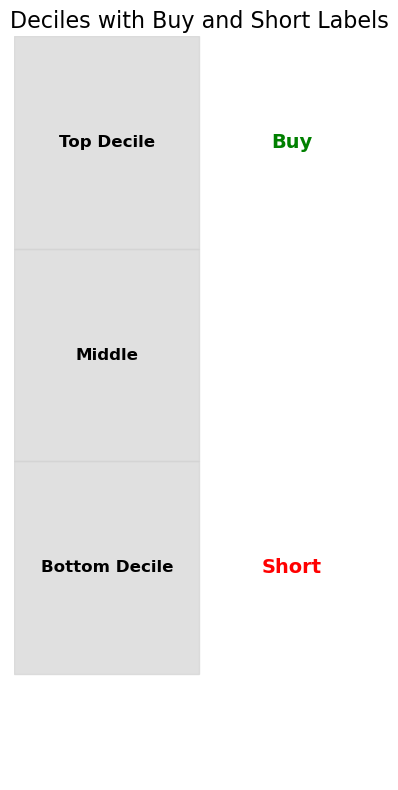

In [183]:
fig, ax = plt.subplots(figsize=(4, 8))

deciles = ["Bottom Decile", "Middle", "Top Decile"]

buy_label = "Buy"
short_label = "Short"

for i, decile in enumerate(deciles):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color='lightgray', alpha=0.7))
    ax.text(0.5, i + 0.5, decile, ha='center', va='center', fontsize=12, fontweight='bold')

ax.text(1.5, 0.5, short_label, ha='center', va='center', fontsize=14, fontweight='bold', color='red')
ax.text(1.5, 2.5, buy_label, ha='center', va='center', fontsize=14, fontweight='bold', color='green')

ax.set_xlim(0, 2)
ax.set_ylim(-0.5, 3)
ax.axis('off') 

plt.title("Deciles with Buy and Short Labels", fontsize=16)

plt.tight_layout()
plt.show()

### Simulation and Analysis

### a. Decile Strategy (Z-Scored Ratios)

<span style="color: rgb(0, 0, 128);"> This code implements a trading strategy based on previously calculated financial ratios. The primary goal of this strategy is to generate profits by taking long (buy) and short (short-sell) positions in different stocks based on their financial ratios. The code iterates through a set of financial ratio columns , as well as two different weighting strategies: 'equally_weighted' and 'mkt_val_weighted'. For each combination of financial ratio and weighting strategy, it calculates the potential profits (PnL) over a historical dataset of stocks. The strategy first divides the stocks into deciles based on the chosen financial ratio and then takes positions (long or short) in the top and bottom deciles. The size of the positions is determined by either equal weighting or market capitalization weighting, depending on the chosen strategy. Additionally, it calculates the PnL, including adjustments for a fixed funding rate and repo cash flow. The final results are stored in a DataFrame called strategies_df, which ranks the strategies by their PnL in descending order. Here, I am assuming an initial capital of $1 million, trading amount of $250,000, and a fixed funding rate of 0.02. </span> 

In [186]:
t_trading_z['date'] = pd.to_datetime(t_trading_z['date'])

columns = ['z_debt_to_market_cap_ratio', 'z_return_on_investment_ratio', 
           'z_price_to_earnings_ratio', 'z_non_trivial_comb_ratio']

weighting_strategies = ['equally_weighted', 'mkt_val_weighted']
initial_capital = 1000000  # Total initial capital
trade_amount = 250000  # Amount to trade each month for long and short positions
repo_rate = 0.01 #Fixed funding rate = 0.02 - 100bp

strategies_df = pd.DataFrame()

for column in columns:
    for weighting_strategy in weighting_strategies:
        unique_dates = t_trading_z['date'].unique()
        all_data = t_trading_z[t_trading_z['date'].isin(unique_dates)].copy()

        if all_data.groupby('date')[column].count().min() < 4:
            continue

        deciles = all_data.groupby('date')[column].transform(
            lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=False, duplicates='drop')
        )

        all_data['Decile'] = deciles
        all_data['Position'] = 0

        if weighting_strategy == 'equally_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                top_decile = date_data[date_data['Decile'] == 2]['mkt_val'].count()
                bottom_decile = date_data[date_data['Decile'] == 0]['mkt_val'].count()
                if top_decile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 2), 'Position'] = trade_amount / top_decile
                if bottom_decile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 0), 'Position'] = -(trade_amount / bottom_decile)

        elif weighting_strategy == 'mkt_val_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                total_mkt_val_top = date_data[date_data['Decile'] == 2]['mkt_val'].sum()
                total_mkt_val_bottom = date_data[date_data['Decile'] == 0]['mkt_val'].sum()
                all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 2), 'Position'] = \
                    all_data['mkt_val'] / total_mkt_val_top * trade_amount
                all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 0), 'Position'] = \
                    -(all_data['mkt_val'] / total_mkt_val_bottom * trade_amount)

        # PnL calculation
        pnl = all_data.groupby('ticker').apply(
            lambda x: x['Position'] * (x['adj_close'].iloc[-1] - x['adj_close'].iloc[0])
        ).sum()

        # Repo cash flow adjustment (simplified for demonstration)
        repo_cash_flow = repo_rate * all_data.loc[all_data['Position'] < 0, 'Position'].sum()

        strategy_name = f"{column}_{weighting_strategy}"
        strategies_df.at[strategy_name, 'PnL'] = (pnl + repo_cash_flow)/1000

strategies_df = strategies_df.sort_values(by='PnL', ascending=False)
strategies_df.reset_index(inplace=True)
strategies_df.rename(columns={'index': 'Strategy'}, inplace=True)
strategies_df

,Strategy,PnL
0,z_return_on_investment_ratio_mkt_val_weighted,1.377196e+06
1,z_price_to_earnings_ratio_mkt_val_weighted,1.341334e+06
2,z_non_trivial_comb_ratio_mkt_val_weighted,6.459854e+05
3,z_return_on_investment_ratio_equally_weighted,5.173130e+05
4,z_debt_to_market_cap_ratio_mkt_val_weighted,2.832351e+05
5,z_debt_to_market_cap_ratio_equally_weighted,-1.009498e+06
6,z_price_to_earnings_ratio_equally_weighted,-2.520732e+06
7,z_non_trivial_comb_ratio_equally_weighted,-2.565702e+06


<span style="color: rgb(255,69,0);"> As shown in the table above, we see that our z-scored financial ratio trading strategies predominantly performed better using the market_val_weighted strategy vs the equally_weighted strategy. The best strategy was the one that used the return on investment ratio to determine deciles and market value to determine weighting. Additionally, the worst performing strategy was the one that used the non-trivial combination of all 3 financial ratios (weighted sum) to determine deciles with equall weights. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the results from the dataframe displayed above to vizualize the relative profit and loss for each trading strategy. </span> 

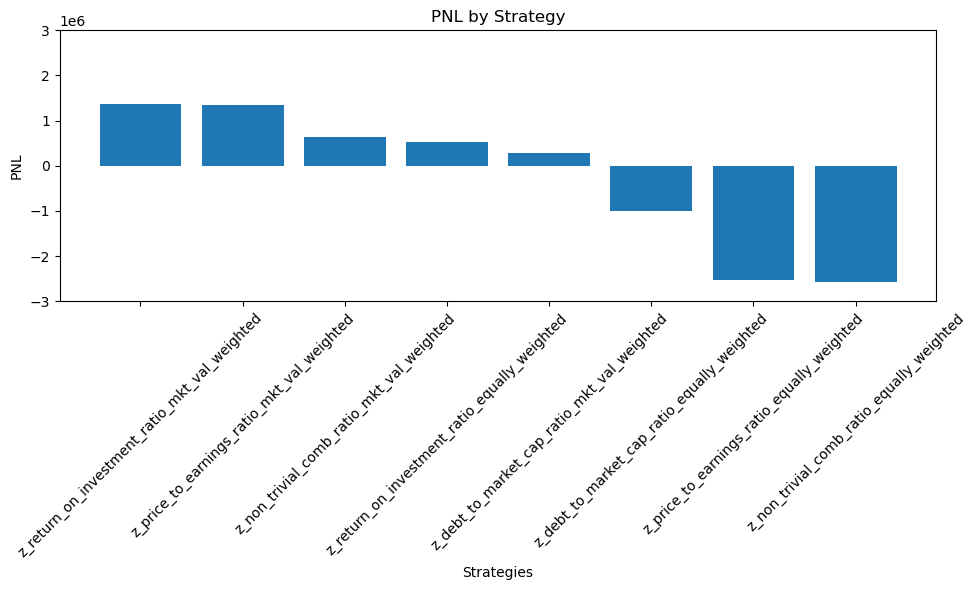

In [168]:
# Extract the strategy names and PNL values
strategies = strategies_df['Strategy'].tolist()  # Assuming strategy names are in the DataFrame's index
pnl_values = strategies_df['PnL'].tolist()

# Create a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the PNL values for each strategy
plt.bar(range(len(strategies)), pnl_values, tick_label=strategies)
plt.xlabel('Strategies')
plt.ylabel('PNL')
plt.title('PNL by Strategy')

plt.ylim(-3000000, 3000000)
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### b. Decile Strategy (Z-Scored % Change in Ratios)

<span style="color: rgb(0, 0, 128);"> This code implements the same trading strategy described above but now for the percent changes for each of the financial ratios (normalized) </span> 

In [188]:
t_trading_z['date'] = pd.to_datetime(t_trading_z['date'])

columns = ['z_pct_chnge_debt_to_market_cap_ratio', 'z_pct_chnge_return_on_investment_ratio', 
           'z_pct_chnge_price_to_earnings_ratio', 'z_pct_chnge_non_trivial_comb_ratio']

weighting_strategies = ['equally_weighted', 'mkt_val_weighted']
initial_capital = 1000000  # Total initial capital
trade_amount = 250000  # Amount to trade each month for long and short positions
repo_rate = 0.01 #Fixed funding rate = 0.02 - 100bp

strategies1_df = pd.DataFrame()

for column in columns:
    for weighting_strategy in weighting_strategies:
        unique_dates = t_trading_z['date'].unique()
        all_data = t_trading_z[t_trading_z['date'].isin(unique_dates)].copy()

        if all_data.groupby('date')[column].count().min() < 4:
            continue

        deciles = all_data.groupby('date')[column].transform(
            lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=False, duplicates='drop')
        )

        all_data['Decile'] = deciles
        all_data['Position'] = 0

        if weighting_strategy == 'equally_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                top_decile = date_data[date_data['Decile'] == 2]['mkt_val'].count()
                bottom_decile = date_data[date_data['Decile'] == 0]['mkt_val'].count()
                if top_decile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 2), 'Position'] = trade_amount / top_decile
                if bottom_decile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 0), 'Position'] = -(trade_amount / bottom_decile)

        elif weighting_strategy == 'mkt_val_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                total_mkt_val_top = date_data[date_data['Decile'] == 2]['mkt_val'].sum()
                total_mkt_val_bottom = date_data[date_data['Decile'] == 0]['mkt_val'].sum()
                all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 2), 'Position'] = \
                    all_data['mkt_val'] / total_mkt_val_top * trade_amount
                all_data.loc[(all_data['date'] == date) & (all_data['Decile'] == 0), 'Position'] = \
                    -(all_data['mkt_val'] / total_mkt_val_bottom * trade_amount)

        # PnL calculation
        pnl = all_data.groupby('ticker').apply(
            lambda x: x['Position'] * (x['adj_close'].iloc[-1] - x['adj_close'].iloc[0])
        ).sum()

        # Repo cash flow adjustment (simplified for demonstration)
        repo_cash_flow = repo_rate * all_data.loc[all_data['Position'] < 0, 'Position'].sum()

        strategy_name = f"{column}_{weighting_strategy}"
        strategies1_df.at[strategy_name, 'PnL'] = (pnl + repo_cash_flow)/1000

strategies1_df.reset_index(inplace=True)
strategies1_df.rename(columns={'index': 'Strategy'}, inplace=True)
strategies1_df = strategies1_df.sort_values(by='PnL', ascending=False)
strategies1_df

,Strategy,PnL
7,z_pct_chnge_non_trivial_comb_ratio_mkt_val_wei...,3.019414e+06
5,z_pct_chnge_price_to_earnings_ratio_mkt_val_we...,1.790897e+06
1,z_pct_chnge_debt_to_market_cap_ratio_mkt_val_w...,1.028023e+06
3,z_pct_chnge_return_on_investment_ratio_mkt_val...,5.252497e+05
0,z_pct_chnge_debt_to_market_cap_ratio_equally_w...,4.863110e+05
2,z_pct_chnge_return_on_investment_ratio_equally...,-3.074156e+05
4,z_pct_chnge_price_to_earnings_ratio_equally_we...,-1.844403e+06
6,z_pct_chnge_non_trivial_comb_ratio_equally_wei...,-1.800496e+07


<span style="color: rgb(255,69,0);"> As shown in the table above, we see that our z-scored financial ratio trading strategies for % change data again predominantly performed better using the market_val_weighted strategy vs the equally_weighted strategy. The best strategy was the one that used the non-trivial combination ratio (weighted sum of all 3 ratios: 50% return on investment, 25% price to earning, and 25% debt to market cap ratio) to determine deciles and market value to determine weighting. Additionally, the worst performing strategy was the one that used the non-trivial combination of all 3 financial ratios (weighted sum) to determine deciles with equall weights. These PnL values are generally higher than those observed using the raw financial ratio values (normalized). </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the results from the dataframe displayed above to vizualize the relative profit and loss for each trading strategy. </span> 

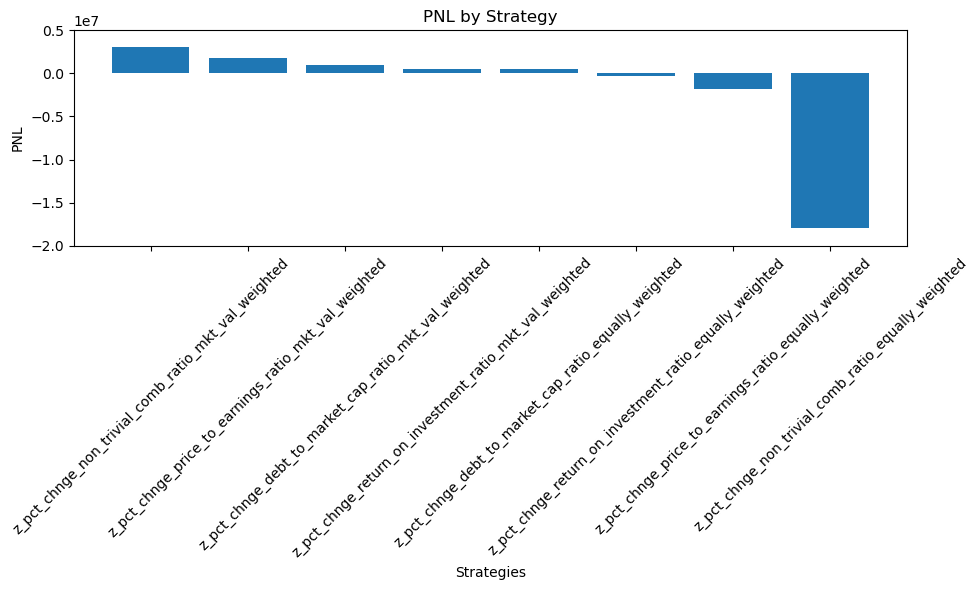

In [190]:
# Extract the strategy names and PNL values
strategies = strategies1_df['Strategy'].tolist()  # Assuming strategy names are in the DataFrame's index
pnl_values = strategies1_df['PnL'].tolist()

# Create a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the PNL values for each strategy
plt.bar(range(len(strategies)), pnl_values, tick_label=strategies)
plt.xlabel('Strategies')
plt.ylabel('PNL')
plt.title('PNL by Strategy')

plt.ylim(-20000000, 5000000)
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### c. Quartile Strategy (Z-Scored Ratios)

<span style="color: rgb(0, 0, 128);"> This code implements a trading strategy based on buying the top quartile and shorting the bottom quartile. </span> 

In [191]:
t_trading_z['date'] = pd.to_datetime(t_trading_z['date'])

columns = ['z_debt_to_market_cap_ratio', 'z_return_on_investment_ratio', 
           'z_price_to_earnings_ratio', 'z_non_trivial_comb_ratio']

weighting_strategies = ['equally_weighted', 'mkt_val_weighted']
initial_capital = 1000000  # Total initial capital
trade_amount = 250000  # Amount to trade each month for long and short positions
repo_rate = 0.01  # Fixed funding rate = 0.02 - 100bp

strategies2_df = pd.DataFrame()

for column in columns:
    for weighting_strategy in weighting_strategies:
        unique_dates = t_trading_z['date'].unique()
        all_data = t_trading_z[t_trading_z['date'].isin(unique_dates)].copy()

        if all_data.groupby('date')[column].count().min() < 4:
            continue

        quartiles = all_data.groupby('date')[column].transform(
            lambda x: pd.qcut(x, q=[0, 0.25, 0.75, 1.0], labels=False, duplicates='drop')
        )

        all_data['Quartile'] = quartiles
        all_data['Position'] = 0

        if weighting_strategy == 'equally_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                top_quartile = date_data[date_data['Quartile'] == 2]['mkt_val'].count()
                bottom_quartile = date_data[date_data['Quartile'] == 0]['mkt_val'].count()
                if top_quartile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Quartile'] == 2), 'Position'] = trade_amount / top_quartile
                if bottom_quartile > 0:
                    all_data.loc[(all_data['date'] == date) & (all_data['Quartile'] == 0), 'Position'] = -(trade_amount / bottom_quartile)

        elif weighting_strategy == 'mkt_val_weighted':
            for date in unique_dates:
                date_data = all_data[all_data['date'] == date]
                total_mkt_val_top = date_data[date_data['Quartile'] == 2]['mkt_val'].sum()
                total_mkt_val_bottom = date_data[date_data['Quartile'] == 0]['mkt_val'].sum()
                all_data.loc[(all_data['date'] == date) & (all_data['Quartile'] == 2), 'Position'] = \
                    all_data['mkt_val'] / total_mkt_val_top * trade_amount
                all_data.loc[(all_data['date'] == date) & (all_data['Quartile'] == 0), 'Position'] = \
                    -(all_data['mkt_val'] / total_mkt_val_bottom * trade_amount)

        # PnL calculation
        pnl = all_data.groupby('ticker').apply(
            lambda x: x['Position'] * (x['adj_close'].iloc[-1] - x['adj_close'].iloc[0])
        ).sum()

        # Repo cash flow adjustment (simplified for demonstration)
        repo_cash_flow = repo_rate * all_data.loc[all_data['Position'] < 0, 'Position'].sum()

        strategy_name = f"{column}_{weighting_strategy}"
        strategies2_df.at[strategy_name, 'PnL'] = (pnl + repo_cash_flow) / 1000

strategies2_df.reset_index(inplace=True)
strategies2_df.rename(columns={'index': 'Strategy'}, inplace=True)
strategies2_df = strategies2_df.sort_values(by='PnL', ascending=False)
strategies2_df

,Strategy,PnL
4,z_price_to_earnings_ratio_equally_weighted,9.267366e+05
6,z_non_trivial_comb_ratio_equally_weighted,7.579781e+05
2,z_return_on_investment_ratio_equally_weighted,6.440050e+05
5,z_price_to_earnings_ratio_mkt_val_weighted,1.546088e+05
7,z_non_trivial_comb_ratio_mkt_val_weighted,6.953670e+04
1,z_debt_to_market_cap_ratio_mkt_val_weighted,-4.415131e+04
3,z_return_on_investment_ratio_mkt_val_weighted,-6.354171e+05
0,z_debt_to_market_cap_ratio_equally_weighted,-2.033251e+06


<span style="color: rgb(255,69,0);"> As shown in the table above, we see that our z-scored financial ratio trading strategy based on top and bottom quartiles predominantly performed better using the equally weighted strategy vs the market-value weighted strategy. The best strategy was the one that used the price to earnings ratio to determine quartiles and equal weighting. Additionally, the worst performing strategy was the one that used the debt to market cap ratioto determine deciles with equal weights. The PnL is less than that observed for similar strategies using the decile approach. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the results from the dataframe displayed above to vizualize the relative profit and loss for each trading strategy. </span> 

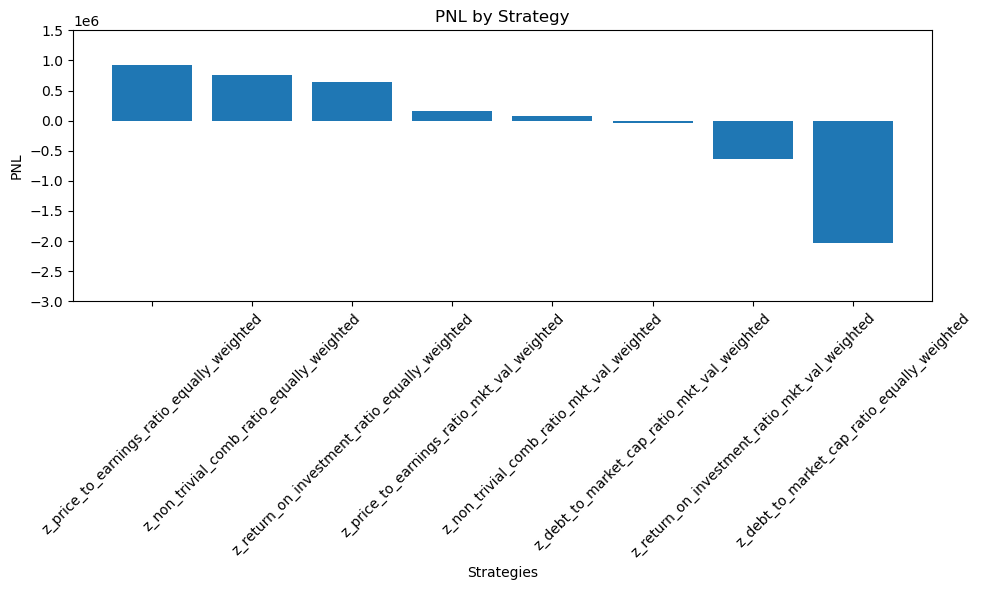

In [197]:
# Extract the strategy names and PNL values
strategies = strategies2_df['Strategy'].tolist()  # Assuming strategy names are in the DataFrame's index
pnl_values = strategies2_df['PnL'].tolist()

# Create a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the PNL values for each strategy
plt.bar(range(len(strategies)), pnl_values, tick_label=strategies)
plt.xlabel('Strategies')
plt.ylabel('PNL')
plt.title('PNL by Strategy')

plt.ylim(-3000000, 1500000)
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### d. Decile Strategy (Z-Scored Ratios) - Holding Strategy [Variation of a]

<span style="color: rgb(0, 0, 128);"> This code implements a trading strategy based on buying the top decile and shorting the bottom decile AND holding positions for the entire duration until the end. In short, there is no rebalancing being done here. </span> 

In [198]:
t_trading_z['date'] = pd.to_datetime(t_trading_z['date'])

columns = ['z_debt_to_market_cap_ratio', 'z_return_on_investment_ratio', 
           'z_price_to_earnings_ratio', 'z_non_trivial_comb_ratio']

weighting_strategies = ['equally_weighted', 'mkt_val_weighted']
initial_capital = 1000000  # Total initial capital
trade_amount = 250000  # Amount to trade each month for long and short positions
repo_rate = 0.01  # Fixed funding rate = 0.02 - 100bp

strategies3_df = pd.DataFrame()

for column in columns:
    for weighting_strategy in weighting_strategies:
        all_data = t_trading_z.copy()

        deciles = all_data.groupby('date')[column].transform(
            lambda x: pd.qcut(x, q=[0, 0.1, 0.9, 1.0], labels=False, duplicates='drop')
        )

        all_data['Decile'] = deciles
        all_data['Position'] = 0

        if weighting_strategy == 'equally_weighted':
            top_decile = all_data[all_data['Decile'] == 2]['mkt_val'].count()
            bottom_decile = all_data[all_data['Decile'] == 0]['mkt_val'].count()
            if top_decile > 0:
                all_data.loc[all_data['Decile'] == 2, 'Position'] = trade_amount / top_decile
            if bottom_decile > 0:
                all_data.loc[all_data['Decile'] == 0, 'Position'] = -(trade_amount / bottom_decile)

        elif weighting_strategy == 'mkt_val_weighted':
            total_mkt_val_top = all_data[all_data['Decile'] == 2]['mkt_val'].sum()
            total_mkt_val_bottom = all_data[all_data['Decile'] == 0]['mkt_val'].sum()
            all_data.loc[all_data['Decile'] == 2, 'Position'] = \
                all_data['mkt_val'] / total_mkt_val_top * trade_amount
            all_data.loc[all_data['Decile'] == 0, 'Position'] = \
                -(all_data['mkt_val'] / total_mkt_val_bottom * trade_amount)

        # PnL calculation based on last available values
        pnl = all_data.groupby('ticker').apply(
            lambda x: x['Position'] * (x['adj_close'].iloc[-1] - x['adj_close'].iloc[0])
        ).sum()

        # Repo cash flow adjustment (simplified for demonstration)
        repo_cash_flow = repo_rate * all_data.loc[all_data['Position'] < 0, 'Position'].sum()

        strategy_name = f"{column}_{weighting_strategy}"
        strategies3_df.at[strategy_name, 'PnL'] = (pnl + repo_cash_flow) / 1000

strategies3_df = strategies3_df.sort_values(by='PnL', ascending=False)
strategies3_df.reset_index(inplace=True)
strategies3_df.rename(columns={'index': 'Strategy'}, inplace=True)
strategies3_df

,Strategy,PnL
0,z_return_on_investment_ratio_mkt_val_weighted,17016.032972
1,z_price_to_earnings_ratio_mkt_val_weighted,3500.949796
2,z_return_on_investment_ratio_equally_weighted,2906.252571
3,z_non_trivial_comb_ratio_mkt_val_weighted,70.270386
4,z_debt_to_market_cap_ratio_equally_weighted,-5671.338820
5,z_debt_to_market_cap_ratio_mkt_val_weighted,-11665.300064
6,z_price_to_earnings_ratio_equally_weighted,-14161.417426
7,z_non_trivial_comb_ratio_equally_weighted,-14414.056532


<span style="color: rgb(255,69,0);"> As shown in the table above, we see that our z-scored financial ratio trading strategies predominantly performed better using the market_val_weighted strategy vs the equally_weighted strategy. The best strategy was the one that used the return on investment ratio to determine deciles and market value to determine weighting. Additionally, the worst performing strategy was the one that used the non-trivial combination of all 3 financial ratios (weighted sum) to determine deciles with equal weights. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the results from the dataframe displayed above to vizualize the relative profit and loss for each trading strategy. </span>

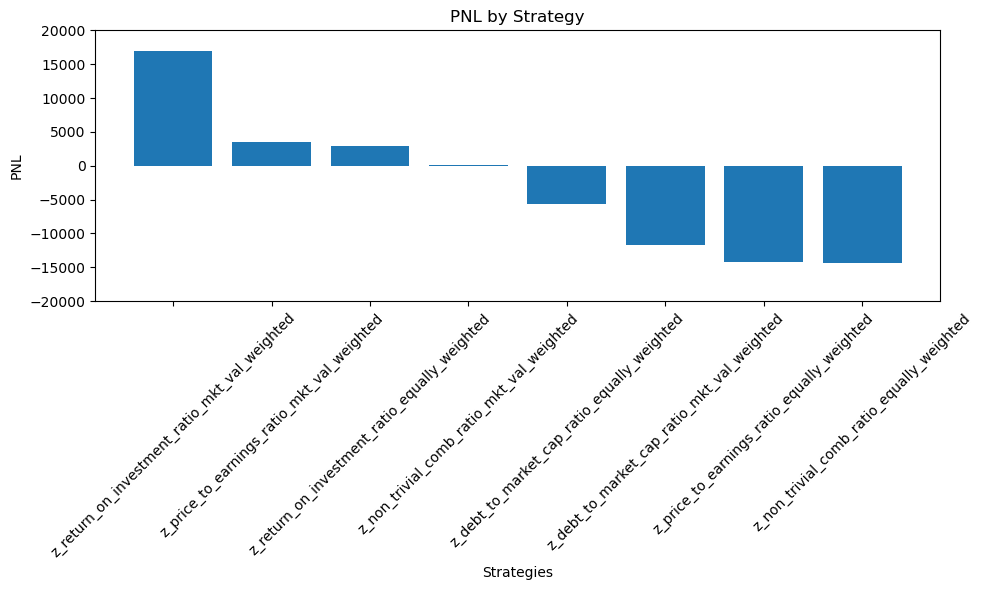

In [201]:
# Extract the strategy names and PNL values
strategies = strategies3_df['Strategy'].tolist()  # Assuming strategy names are in the DataFrame's index
pnl_values = strategies3_df['PnL'].tolist()

# Create a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the PNL values for each strategy
plt.bar(range(len(strategies)), pnl_values, tick_label=strategies)
plt.xlabel('Strategies')
plt.ylabel('PNL')
plt.title('PNL by Strategy')

plt.ylim(-20000, 20000)
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## e. Decile Strategy (Z-Scored Ratios) - [Monthly PnL of a]

<span style="color: rgb(0, 0, 128);"> The code below is the same decile-based strategy for z-scored ratios, however, now monthly PnL is being tracked instead of a cumulative PnL at the end of the trading period. </span>

In [229]:
t_trading_z['date'] = pd.to_datetime(t_trading_z['date'])

columns = ['z_debt_to_market_cap_ratio', 'z_return_on_investment_ratio', 
           'z_price_to_earnings_ratio', 'z_non_trivial_comb_ratio']

weighting_strategies = ['equally_weighted', 'mkt_val_weighted']
trade_amount = 250000  # Amount to trade each month for long and short positions
repo_rate = 0.01  # Fixed funding rate

data_list = []

for column in columns:
    for weighting_strategy in weighting_strategies:
        unique_dates = sorted(t_trading_z['date'].unique())
        strategy_name = f"{column}_{weighting_strategy}"

        for date in unique_dates:
            date_str = pd.to_datetime(date).strftime('%Y-%m')
            date_data = t_trading_z[t_trading_z['date'] == date].copy()

            deciles = pd.qcut(date_data[column], q=[0, 0.1, 0.9, 1.0], labels=False, duplicates='drop')
            date_data['Decile'] = deciles
            date_data['Position'] = 0

            if weighting_strategy == 'equally_weighted':
                top_decile_count = date_data[date_data['Decile'] == 2]['mkt_val'].count()
                bottom_decile_count = date_data[date_data['Decile'] == 0]['mkt_val'].count()
                if top_decile_count > 0:
                    date_data.loc[date_data['Decile'] == 2, 'Position'] = trade_amount / top_decile_count
                if bottom_decile_count > 0:
                    date_data.loc[date_data['Decile'] == 0, 'Position'] = -(trade_amount / bottom_decile_count)
            elif weighting_strategy == 'mkt_val_weighted':
                total_mkt_val_top = date_data[date_data['Decile'] == 2]['mkt_val'].sum()
                total_mkt_val_bottom = date_data[date_data['Decile'] == 0]['mkt_val'].sum()
                if total_mkt_val_top > 0:
                    date_data.loc[date_data['Decile'] == 2, 'Position'] = date_data['mkt_val'] / total_mkt_val_top * trade_amount
                if total_mkt_val_bottom > 0:
                    date_data.loc[date_data['Decile'] == 0, 'Position'] = -(date_data['mkt_val'] / total_mkt_val_bottom * trade_amount)

            # Calculate monthly PnL
            monthly_pnl = (date_data['Position'] * (date_data['adj_close'].shift(-1) - date_data['adj_close'])).sum()
            monthly_repo_cash_flow = repo_rate * date_data.loc[date_data['Position'] < 0, 'Position'].sum()

            # Collecting data
            data_list.append({
                'Month': date_str,
                'Strategy': strategy_name,
                'Monthly PnL': (monthly_pnl + monthly_repo_cash_flow) / 1000
            })

# Creating DataFrame from the collected data
strategies_pnl_df_collected = pd.DataFrame(data_list)

# Aggregating Monthly PnL to ensure uniqueness for the pivot operation
aggregated_data = strategies_pnl_df_collected.groupby(['Month', 'Strategy'])['Monthly PnL'].sum().reset_index()

# Pivoting the aggregated data
strategies_pnl_df_aggregated_pivot = aggregated_data.pivot(index='Month', columns='Strategy', values='Monthly PnL')

strategies_pnl_df_aggregated_pivot

Strategy,z_debt_to_market_cap_ratio_equally_weighted,z_debt_to_market_cap_ratio_mkt_val_weighted,z_non_trivial_comb_ratio_equally_weighted,z_non_trivial_comb_ratio_mkt_val_weighted,z_price_to_earnings_ratio_equally_weighted,z_price_to_earnings_ratio_mkt_val_weighted,z_return_on_investment_ratio_equally_weighted,z_return_on_investment_ratio_mkt_val_weighted
Month,,,,,,,,
2016-02,168940.487598,48629.936629,-4200.549263,50918.679752,-23851.186264,31089.703147,22465.884287,-40591.767461
2016-03,1692.057187,-1848.485023,-4462.531310,12070.362545,-5608.021692,9707.622689,-30948.435885,-23987.252495
2016-04,398.265035,13746.685899,264.356386,12222.983043,-487.150214,9907.691701,-10086.689247,-13248.784687
2016-05,186669.877984,19777.714308,-176372.052687,6795.570552,-177099.345370,4983.387777,-2517.213925,-27367.512752
2016-06,-4360.395118,-1144.748924,-319668.633337,-5062.197208,-323069.155897,-32650.413756,13649.027334,59770.278645
...,...,...,...,...,...,...,...,...
2023-02,54065.979461,72775.627429,-15729.775805,-40395.423267,-15533.920064,-35439.487939,-48630.614872,-56112.633179
2023-03,-3939.520847,22968.018176,-19908.226578,-80242.685973,-18889.887912,-92950.238789,-49174.100771,105996.095640
2023-04,-11495.083461,-16175.798760,6877.563467,48969.184426,6005.752949,49629.430087,-59560.448631,-129089.781155


<span style="color: rgb(0, 0, 128);"> The code below plots the results from the dataframe displayed above to vizualize the change in PnL over time. </span>

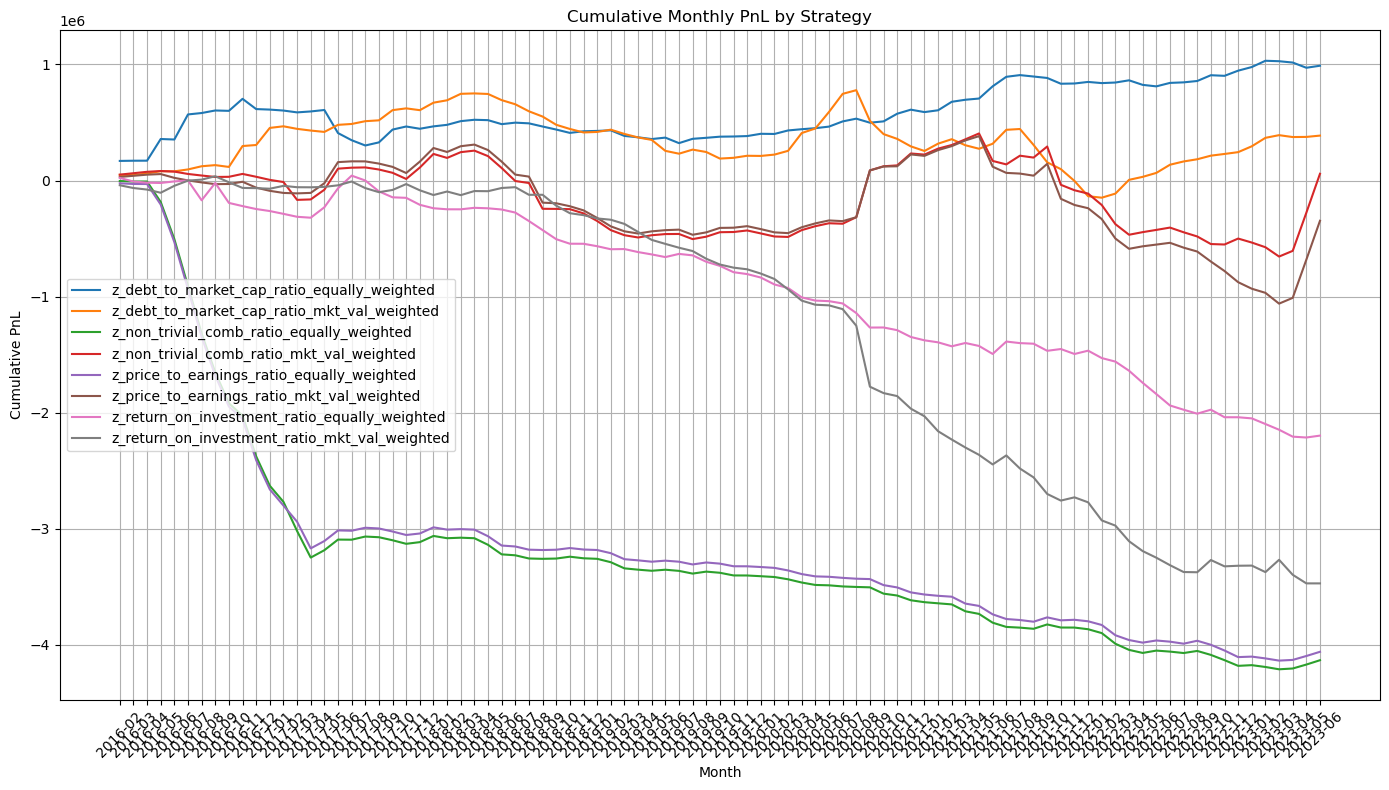

In [210]:
# Calculating cumulative PnL for each strategy
cumulative_pnl = strategies_pnl_df_aggregated_pivot.cumsum()

# Plotting
plt.figure(figsize=(14, 8))
for column in cumulative_pnl.columns:
    plt.plot(cumulative_pnl.index, cumulative_pnl[column], label=column)

plt.title('Cumulative Monthly PnL by Strategy')
plt.xlabel('Month')
plt.ylabel('Cumulative PnL')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color: rgb(0, 0, 128);"> The code below computes the monthly PnL summary statistics and tail metrics for all 8 strategies using the standard decile-based appraoch with monthly rebalancing. </span>

In [221]:
mean = strategies_pnl_df_aggregated_pivot.mean()
median = strategies_pnl_df_aggregated_pivot.median()
std_dev = strategies_pnl_df_aggregated_pivot.std()
sharpe_ratio = mean / std_dev
skewness = strategies_pnl_df_aggregated_pivot.skew()
kurtosis = strategies_pnl_df_aggregated_pivot.kurtosis()

# Define a function to calculate VaR at a 95% confidence level
def calculate_var(series, confidence_level=0.95):
    if isinstance(series, pd.Series):
        return series.quantile(1 - confidence_level)
    else:
        return np.nan

# Define a function to calculate CVaR at a 95% confidence level
def calculate_cvar(series, confidence_level=0.95):
    var = calculate_var(series, confidence_level)
    return series[series <= var].mean()

# Apply VaR and CVaR calculations
var_95 = strategies_pnl_df_aggregated_pivot.apply(calculate_var, confidence_level=0.95)
cvar_95 = strategies_pnl_df_aggregated_pivot.apply(calculate_cvar, confidence_level=0.95)

# Function to calculate Max Drawdown
def max_drawdown(series):
    # Calculate cumulative returns
    cumulative_returns = (1 + series.pct_change()).cumprod()
    # Calculate the running max
    running_max = cumulative_returns.cummax()
    # Calculate the drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Return the Max Drawdown
    return drawdown.min()

# Apply the Max Drawdown function to each column
max_drawdowns = strategies_pnl_df_aggregated_pivot.apply(max_drawdown)

# Combine the statistics into a single DataFrame for easier comparison
stats_summary = pd.DataFrame({
    'Mean': mean,
    'Median': median,
    'Standard Deviation': std_dev,
    'Sharpe Ratio': sharpe_ratio,
    'Skewness': skewness,
    'Max Drawdown': max_drawdowns,
    'Kurtosis': kurtosis,
    'VaR 95%': var_95,
    'CVaR 95%': cvar_95
})

stats_summary

,Mean,Median,Standard Deviation,Sharpe Ratio,Skewness,Max Drawdown,Kurtosis,VaR 95%,CVaR 95%
Strategy,,,,,,,,,
z_debt_to_market_cap_ratio_equally_weighted,11111.255623,8871.619083,52546.179743,0.211457,0.743610,-1.920352,6.129769,-47907.803093,-89260.919993
z_debt_to_market_cap_ratio_mkt_val_weighted,4348.340251,8906.687253,67937.737556,0.064005,-0.425538,-2.465978,2.777735,-109349.518819,-159351.450159
z_non_trivial_comb_ratio_equally_weighted,-46422.234376,-13720.098337,99248.579575,-0.467737,-2.287311,-1.223277,4.810950,-298363.062021,-363617.705216
z_non_trivial_comb_ratio_mkt_val_weighted,655.688688,-2328.185167,98826.024949,0.006635,0.904311,-7.162136,6.024519,-136965.850603,-221480.540187
z_price_to_earnings_ratio_equally_weighted,-45606.194697,-15533.920064,97460.995706,-0.467943,-2.376004,-1.222425,5.400579,-300446.400662,-365396.847965
z_price_to_earnings_ratio_mkt_val_weighted,-3892.424133,-6028.634239,97963.413622,-0.039733,1.116938,-4.295461,6.261311,-106971.017664,-213766.528671
z_return_on_investment_ratio_equally_weighted,-24684.881004,-25526.620234,53409.717463,-0.462180,0.676587,-13.493228,3.216468,-97792.901734,-133983.419723
z_return_on_investment_ratio_mkt_val_weighted,-38987.009175,-35324.755244,73693.426684,-0.529043,-3.177169,-3.183987,20.852352,-132289.014525,-220230.533202


<span style="color: rgb(255,69,0);"> For the strategy z_debt_to_market_cap_ratio_equally_weighted, the summary statistics indicate an average (mean) monthly performance of 11,111.26, with a median performance slightly lower at 8,871.62, suggesting a distribution of returns with a positive skew, as confirmed by the skewness value of 0.74361. The standard deviation, a measure of dispersion or volatility, is relatively high at 52,546.18, which is consistent with the presence of extreme values as suggested by a max drawdown of -1.92035 and a high kurtosis of 6.129769. The positive skewness indicates that there are more frequent small losses and fewer significant gains. The Sharpe Ratio, which measures risk-adjusted return, is relatively low at 0.211457, indicating a modest return for each unit of risk taken. The Value at Risk (VaR) at the 95% confidence level is -47,907.80, which implies that there is a 5% chance that the monthly loss could exceed this value.</span>
<br>
<br>
<span style="color: rgb(255,69,0);">Regarding the z_non_trivial_comb_ratio_equally_weighted strategy, the statistics reflect a notably different performance profile. The mean monthly return is negative at -46,422.23, and the median of -13,720.09 further underscores the negative performance. The strategy experiences high volatility, as indicated by a standard deviation of 99,248.58. This is coupled with a significantly negative skewness of -2.287311 and a max drawdown of -1.223277, highlighting that losses are skewed toward more extreme negative values. The kurtosis of 4.810950 suggests a "fat-tailed" distribution, which means there is a higher likelihood of extreme values compared to a normal distribution. The Sharpe Ratio is negative at -0.467737, which indicates that the risk-adjusted return is negative, and the VaR at the 95% confidence level is -298,363.06, suggesting a 5% chance that the monthly loss could exceed this substantial amount. This strategy appears to carry a higher risk of extreme negative outcomes compared to the first. </span>

## f. SP500 Analysis

<span style="color: rgb(0, 0, 128);"> The code below extracts data for the SP500, calculates monthly returns, and combines the df with the monthly decile-based PnL for each of the 8 trading strategies (using the monthly rebalacing strat for the normalized financial ratios). The, the correlation matrix is visualized. </span>

[*********************100%%**********************]  1 of 1 completed


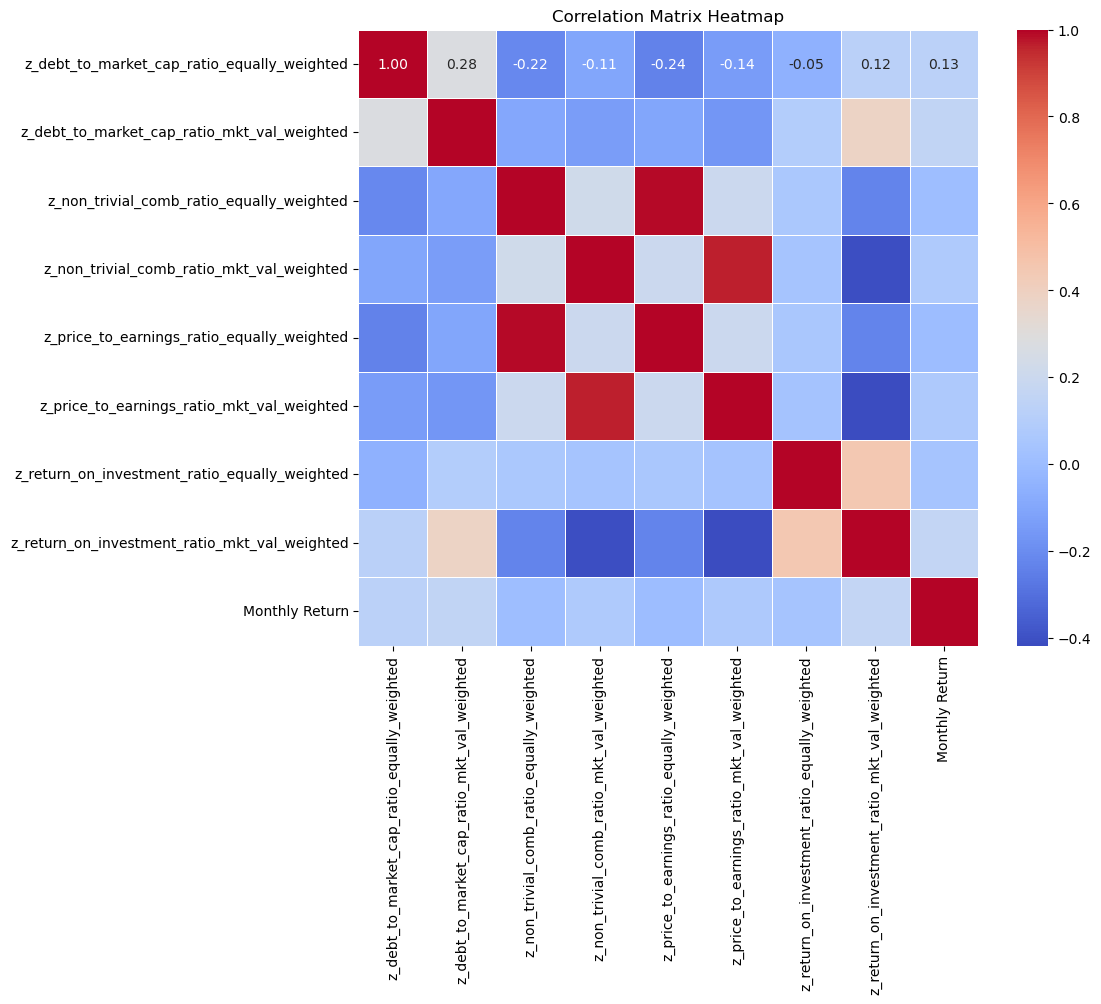

In [243]:
import yfinance as yf

ticker_symbol = '^GSPC'

start_date = '2016-01-01'
end_date = '2023-06-30'

sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1mo')

sp500_data.dropna(how='any', inplace=True)

sp500_data['Monthly Return'] = sp500_data['Adj Close'].pct_change()
sp500_data = sp500_data.iloc[1:]
sp500_data = sp500_data['Monthly Return']

combined_df = pd.concat([strategies_pnl_df_aggregated_pivot.reset_index(drop=True), sp500_data.reset_index(drop=True)], axis=1)

correlation_matrix = combined_df.corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<span style="color: rgb(255,69,0);">As shown above, we can observe the correlation matrix for the different trading strategies amongst themselves along with the monthly returns of the SP500. </span>

## 4. Conclusion

In conclusion, this assignment demonstrated the use of combining data from multiple sources into 1 dataframe, converting quarterly financial ratio data to compute daily values, normalizing values to make comparisons easier, and developing a quantile based trading strategy to determine profit opportunities. 
<br>
<br>
As such, it was observed that market value-weighted portfolios often perform better than equally weighted portfolios due to reasons like: diversification, market efficiency, and momentum effects. Market value-weighted portfolios inherently provide greater diversification. This diversification helps spread risk, making the portfolio less sensitive to the performance of any single stock.
Market value-weighted portfolios are also influenced by market prices and capitalizations, which reflect the collective wisdom and information of all market participants. In efficient markets, prices tend to incorporate all available information, leading to a more accurate reflection of a stock's fundamental value. As a result, market value-weighted portfolios may capture the benefits of market efficiency. Additionally, stocks with higher market capitalizations often also exhibit stronger price momentum, leading to higher demand for larger-cap stocks and potentially better returns.
<br>
<br>
Additionally, it was also observed based on highest realized PnL that the decile strategy performed better than the quartile strategy for the normalized financial ratios. Similarly, the holding strategy seemed to yield very low, almost negligible PnL as compared to both strategies that constantly rebalanced positions every month. Here, it is also important to note that in this assigment, trading costs were not considered. However, in the real world, incorporating trading costs can significantly decrease PnL if rebalancing was done frequently and should be a factor takin into consideration.